In [1]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
import pandas as pd
import csv
import openpyxl
import os
import pickle
import datetime
from scipy import signal
from detecta import detect_peaks
# import matrixprofile as mp
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import mahalanobis
from scipy.spatial.distance import minkowski

# import sktime
import pywt
import cv2 as cv

# from fastdtw import fastdtw
import subprocess
# from dtw import dtw

import warnings
warnings.simplefilter("ignore")
from platform import python_version
print(python_version())
import time

3.9.2


# Read Wrist and Annotation Data

## Fuctions for Reading the Data

In [2]:
def readData(accDir, annotFile):
    files = os.listdir(accDir)
    files_csv = [f for f in files if f[-3:] == 'csv']
    empatica_dict = dict()
    for f in files_csv:
        data = np.genfromtxt(accDir+f, delimiter=',') # creates numpy array for each Empatica acc csv file
        key = int(float(f.strip("ACC.csv")))
        empatica_dict[key] = data
    tmp = pd.read_excel(annotFile, sheet_name=None)
    annot_dict = dict(zip(tmp.keys(), [i.dropna() for i in tmp.values()])) # Remove the rows with NaN values (some with ladder 2 missing)
    return empatica_dict, annot_dict

def getLabeledDict(empatica_dict, annot_dict, subject_ids):
    labeled_dict = {}; taskInd_dict = {}
    for id in subject_ids:
        start_time = int(empatica_dict[id][0,0])
        acc = empatica_dict[id][2:,:]
        label = list(map(lambda i: i.replace("_end", "").replace("_start", ""), annot_dict['P'+ str(id)].taskName.tolist()))
        task_time= list(map(lambda i: time.mktime(datetime.datetime.strptime(i[:6] + '20' + i[6:], "%m/%d/%Y %H:%M:%S").timetuple()),
                            annot_dict['P'+ str(id)].startTime_global.tolist()))
        task_ind = [int(x - start_time)*SR for x in task_time]
        taskInd_dict[id] = task_ind
        label_tmp = np.empty(acc.shape[0], dtype=object)
        for i, (j, k) in enumerate(zip(task_ind[0::2], task_ind[1::2])):
            tmpInd = 2*i
            label_tmp[j:k] = label[tmpInd]
        acc_mag = np.sqrt(np.sum(acc**2, axis=1))[:,None]
        accel = np.hstack((acc, acc_mag))
        labeled_dict[id] = pd.DataFrame(np.hstack((accel, label_tmp.reshape(label_tmp.shape[0],1))), columns=['X', 'Y', 'Z', 'Mag', 'label'])
    return labeled_dict, taskInd_dict

## Read the Data

In [3]:
sepAccDict, sepAnnotDict = readData(accDir='./Data/50_subs/Acc Data/separate/', annotFile='./Data/50_subs/Annotation Data/separate.xlsx')
SR=int(sepAccDict[8][1,0])

sepSubIDs = list(range(8,45))
sepSubIDs.remove(27) # does not have lift
sepLabeledDict_, sepTaskIndDict = getLabeledDict(sepAccDict, sepAnnotDict, sepSubIDs)

## Apply Low Pass Filter

In [4]:
# Apply Filter on All Subjects
n=4; fc=2; w=fc/(SR/2)
b, a = signal.butter(n, w, 'low')
sepLabeledDict_filtered = dict(map(lambda key: (key, signal.filtfilt(b, a, x=sepLabeledDict_[key].drop(columns='label'), axis=0)), sepLabeledDict_.keys()))
# back to DF and add label
sepLabeledDict_filtered_dfs = dict(map(lambda key: (
                                                        key, pd.DataFrame(sepLabeledDict_filtered[key],columns=['X', 'Y', 'Z', 'Mag']).assign(label=sepLabeledDict_[key].label)
                                                    ), sepLabeledDict_filtered.keys()))
# Remove data without label
filt_noNA_dict = dict(map(lambda key: (key, sepLabeledDict_filtered_dfs[key].dropna()), sepLabeledDict_filtered_dfs.keys()))

In [5]:
%matplotlib widget
# %matplotlib notebook
# %matplotlib inline

In [6]:
f, ax = plt.subplots(1, figsize=(13,4))
filt_noNA_dict[8].plot(ax=ax)
# ax.set_xlim([30000, 32000])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:>

## Isolate all Tasks for one Subject

In [18]:
label = filt_noNA_dict[8].label.unique()
i = 4
f, ax = plt.subplots(1, figsize=(13,4))
filt_noNA_dict[8][filt_noNA_dict[8].label==label[i]].plot(ax=ax, legend=True)
ax.set_title(label[i])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Power Spectrum of Y Signal

## Lift subject 8

In [10]:
tmp = pywt.wavelist(kind='continuous')
print(tmp)

['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


In [7]:
label = 'lift'
sub = 8
sig = filt_noNA_dict[sub][filt_noNA_dict[sub].label==label].Y.values

In [17]:
################# For setting the contourlevels
SR=1/32
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2

power_logscale = np.log2(power)
for_hist =power_logscale.flatten()
f, ax = plt.subplots(1,1, figsize=(13,4))
ax.hist(for_hist, bins=100, edgecolor='w')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [15]:
SR=1/32
time = np.arange(0, sig.shape[0]) * SR
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2
contourlevels = np.arange(0, 20)

############################### Plot
f, ax = plt.subplots(figsize=(13, 5))
im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=plt.cm.seismic)# np.log2(power)
ax.set_title('Wavelet Transform (Power Spectrum) of signal', fontsize=20)
ax.set_ylabel('Frequency (Hz)', fontsize=18)
ax.set_xlabel('Time (seconds)', fontsize=18)
cbar_ax = f.add_axes([0.91, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax, orientation="vertical")
yticks = np.arange(np.log2(frequencies).min(), np.log2(frequencies).max())
ax.set_yticks(yticks)
ax.set_yticklabels(np.round(2**(yticks), 1))
# ax.set_xlim([0, 50])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [23]:
f, ax = plt.subplots(1, figsize=(13,5))
ax.imshow(power, cmap='gray', aspect=10)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [27]:
## Thresholding on powerespectrom to binarize the image
power_20perc = np.percentile(power, 80)
power_binary = np.zeros(shape=power.shape)
power_binary[np.where(power>power_20perc)]=255

############# Plot
f, ax = plt.subplots(1, figsize=(13,5))
ax.imshow(power_binary, cmap='gray', aspect=10)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Lift in subject 9

In [572]:
label = 'lift'
sub = 9
sig = filt_noNA_dict[sub][filt_noNA_dict[sub].label==label].Y.values

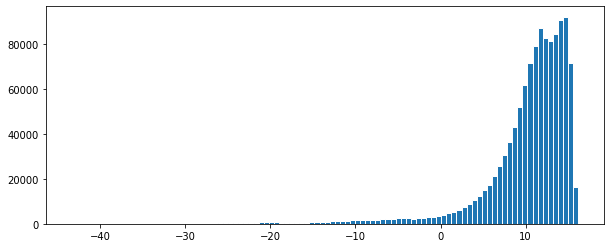

In [574]:
################# For setting the contourlevels
SR=1/32
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2

power_logscale = np.log2(power)
for_hist =power_logscale.flatten()
f, ax = plt.subplots(1,1, figsize=(10,4))
ax.hist(for_hist, bins=100, edgecolor='w')
plt.show()

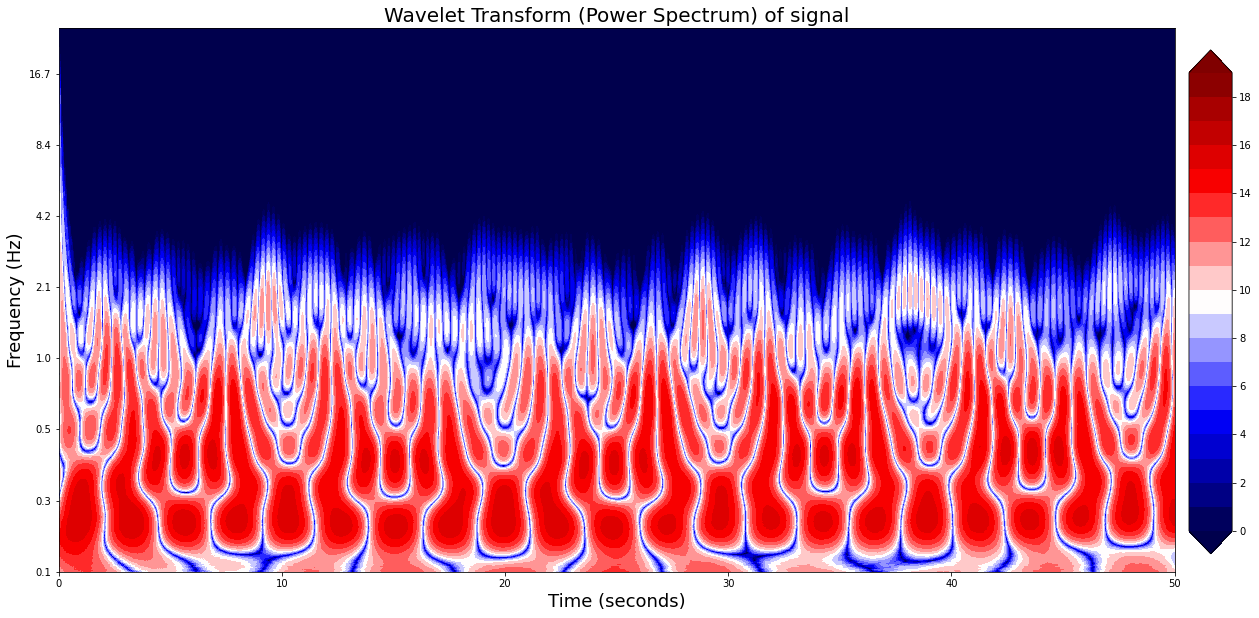

In [575]:
SR=1/32
time = np.arange(0, sig.shape[0]) * SR
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2
contourlevels = np.arange(0, 20)

############################### Plot
f, ax = plt.subplots(figsize=(20, 10))
im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=plt.cm.seismic)# np.log2(power)
ax.set_title('Wavelet Transform (Power Spectrum) of signal', fontsize=20)
ax.set_ylabel('Frequency (Hz)', fontsize=18)
ax.set_xlabel('Time (seconds)', fontsize=18)
cbar_ax = f.add_axes([0.91, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax, orientation="vertical")
yticks = np.arange(np.log2(frequencies).min(), np.log2(frequencies).max())
ax.set_yticks(yticks)
ax.set_yticklabels(np.round(2**(yticks), 1))
ax.set_xlim([0, 50])
plt.show()

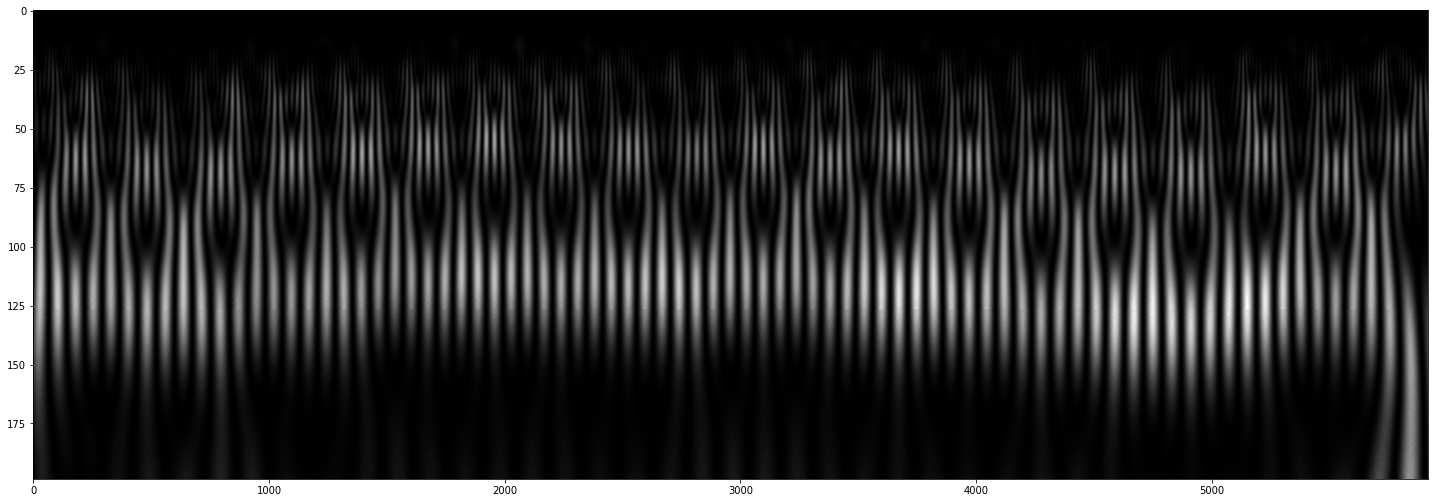

In [576]:
f, ax = plt.subplots(1, figsize=(25,10))
ax.imshow(power, cmap='gray', aspect=10)
plt.show()

number of detected contours = 20.0


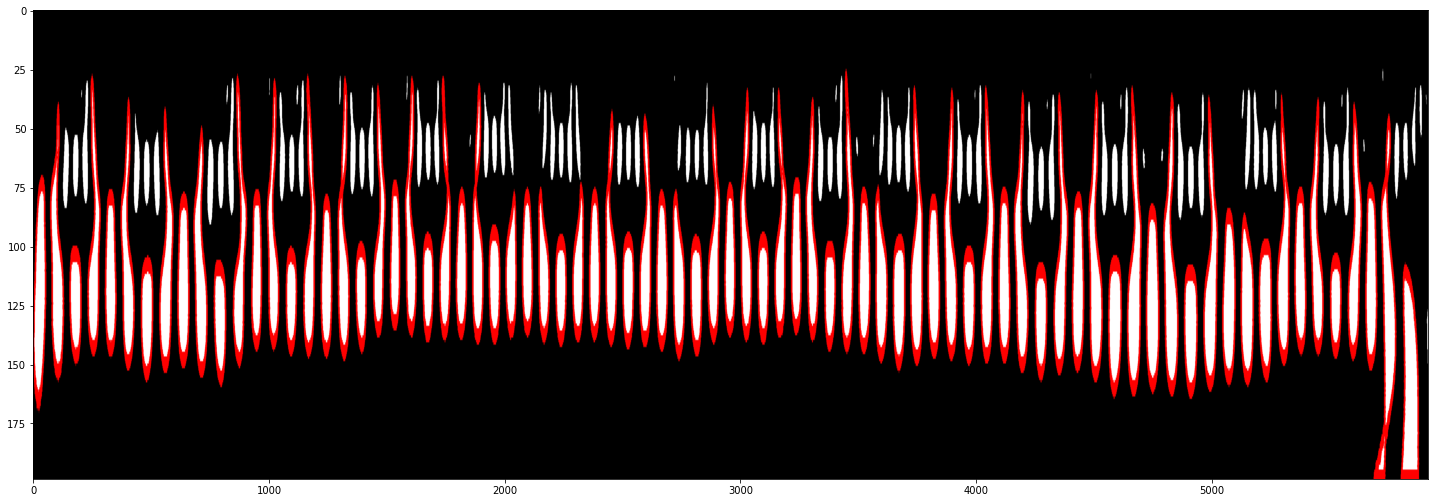

In [594]:
power_20perc = np.percentile(power, 80)
# power_binary = np.zeros(shape=power.shape)
# power_binary[np.where(power>power_20perc)]=255
ret, thresh_img = cv.threshold(power, power_20perc, 255, cv.THRESH_BINARY)
thresh_img = thresh_img.astype('uint8')

contours, hierarchy = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
area = [cv.contourArea(cnt) for cnt in contours]
area_thresh = np.percentile(area, 90)*0.3
contours_np = np.array(contours)
area_np = np.array(area)
large_contours = contours_np[np.where(area_np>area_thresh)]
print('number of detected contours = {}'.format(round(large_contours.shape[0]/4, 0)))

######### Plot
f, ax = plt.subplots(figsize=(25,10))
im = np.expand_dims(thresh_img.copy(), axis=2).repeat(3, axis=2) 
for k, _ in enumerate(large_contours):
    im = cv.drawContours(im, large_contours, k, (255, 0, 0), 6)
plt.imshow(im, aspect=10)
plt.show()

## Entire signal Y sub 8

In [20]:
# label = 'lift'
sub = 9
sig = filt_noNA_dict[sub].Y.values

In [29]:
################# For setting the contourlevels
SR=1/32
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2

power_logscale = np.log2(power)
for_hist =power_logscale.flatten()
f, ax = plt.subplots(1,1, figsize=(10,4))
ax.hist(for_hist, bins=100, edgecolor='w')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [21]:
SR=1/32
time = np.arange(0, sig.shape[0]) * SR
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2
contourlevels = np.arange(-20, 20)

In [31]:
############################### Plot
f, ax = plt.subplots(figsize=(13, 5))
im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=plt.cm.seismic)
ax.set_title('Wavelet Transform (Power Spectrum) of signal', fontsize=20)
ax.set_ylabel('Frequency (Hz)', fontsize=18)
ax.set_xlabel('Time (seconds)', fontsize=18)
cbar_ax = f.add_axes([0.91, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax, orientation="vertical")
yticks = np.arange(np.log2(frequencies).min(), np.log2(frequencies).max())
ax.set_yticks(yticks)
ax.set_yticklabels(np.round(2**(yticks), 1))
# ax.set_xlim([0, 50])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [32]:
############################### Plot
f, ax = plt.subplots(figsize=(13, 5))
im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap='gray')
ax.set_title('Wavelet Transform (Power Spectrum) of signal', fontsize=20)
ax.set_ylabel('Frequency (Hz)', fontsize=18)
ax.set_xlabel('Time (seconds)', fontsize=18)
cbar_ax = f.add_axes([0.91, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax, orientation="vertical")
yticks = np.arange(np.log2(frequencies).min(), np.log2(frequencies).max())
ax.set_yticks(yticks)
ax.set_yticklabels(np.round(2**(yticks), 1))
# ax.set_xlim([0, 50])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [36]:
#######
# label = 'lift'
sub = 9
sig = filt_noNA_dict[sub].Y.values

#######
SR=1/32
time = np.arange(0, sig.shape[0]) * SR
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2

## Thresholding on powerespectrom to binarize the image
power_20perc = np.percentile(power, 80)
power_binary = np.zeros(shape=power.shape)
power_binary[np.where(power>power_20perc)]=255

############# Plot
f, ax = plt.subplots(1, figsize=(13,5))
ax.imshow(power_binary, cmap='gray', aspect=100)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [35]:
#######
# label = 'lift'
sub = 9
sig = filt_noNA_dict[sub].Y.values

#######
SR=1/32
time = np.arange(0, sig.shape[0]) * SR
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2

## Thresholding on powerespectrom to binarize the image
power_20perc = np.percentile(power, 80)
power_binary = np.zeros(shape=power.shape)
power_binary[np.where(power>power_20perc)]=255

power_binary[35:, :] = 0

# power_20perc = np.percentile(power, 80)
# ret, thresh_img__ = cv.threshold(power, power_20perc, 255, cv.THRESH_BINARY)
# thresh_img_ = thresh_img__.astype('uint8')
# thresh_img = thresh_img_[20:35,:]

############# Plot
f, ax = plt.subplots(1, figsize=(13,5))
ax.imshow(power_binary, cmap='gray', aspect=50)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
#######
# label = 'lift'
sub = 9
sig = filt_noNA_dict[sub].Y.values

#######
SR=1/32
time = np.arange(0, sig.shape[0]) * SR
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2

## Thresholding on powerespectrom to binarize the image
power_20perc = np.percentile(power, 80)
power_binary = np.zeros(shape=power.shape)
power_binary[np.where(power>power_20perc)]=255

power_binary[80:, :] = 0

# power_20perc = np.percentile(power, 80)
# ret, thresh_img__ = cv.threshold(power, power_20perc, 255, cv.THRESH_BINARY)
# thresh_img_ = thresh_img__.astype('uint8')
# thresh_img = thresh_img_[20:35,:]

############# Plot
f, ax = plt.subplots(1, figsize=(13,5))
ax.imshow(power_binary, cmap='gray', aspect=50)
plt.show()

In [27]:
type(thresh_img__), thresh_img__.shape

(numpy.ndarray, (199, 58528))

In [29]:
sig.shape, power.shape

((58528,), (199, 58528))

In [30]:
np.unique(thresh_img__)

array([  0., 255.])

## Lift in subject 10

In [595]:
label = 'lift'
sub = 10
sig = filt_noNA_dict[sub][filt_noNA_dict[sub].label==label].Y.values

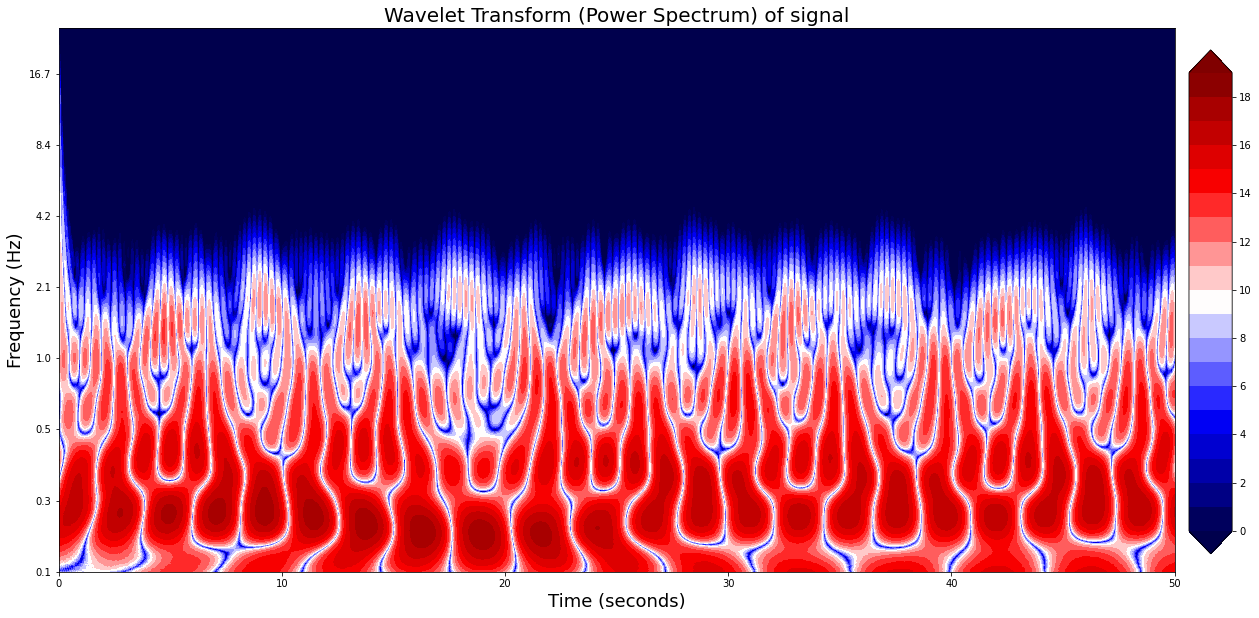

In [596]:
SR=1/32
time = np.arange(0, sig.shape[0]) * SR
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2
contourlevels = np.arange(0, 20)

############################### Plot
f, ax = plt.subplots(figsize=(20, 10))
im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=plt.cm.seismic)# np.log2(power)
ax.set_title('Wavelet Transform (Power Spectrum) of signal', fontsize=20)
ax.set_ylabel('Frequency (Hz)', fontsize=18)
ax.set_xlabel('Time (seconds)', fontsize=18)
cbar_ax = f.add_axes([0.91, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax, orientation="vertical")
yticks = np.arange(np.log2(frequencies).min(), np.log2(frequencies).max())
ax.set_yticks(yticks)
ax.set_yticklabels(np.round(2**(yticks), 1))
ax.set_xlim([0, 50])
plt.show()

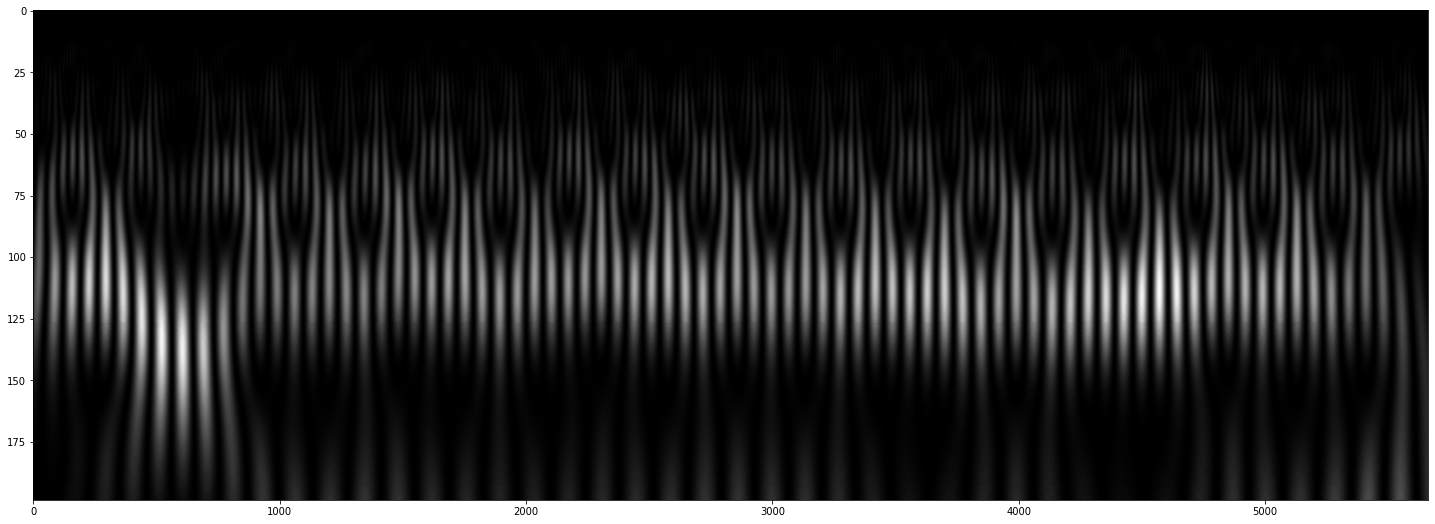

In [597]:
f, ax = plt.subplots(1, figsize=(25,10))
ax.imshow(power, cmap='gray', aspect=10)
plt.show()

number of detected contours = 20.0


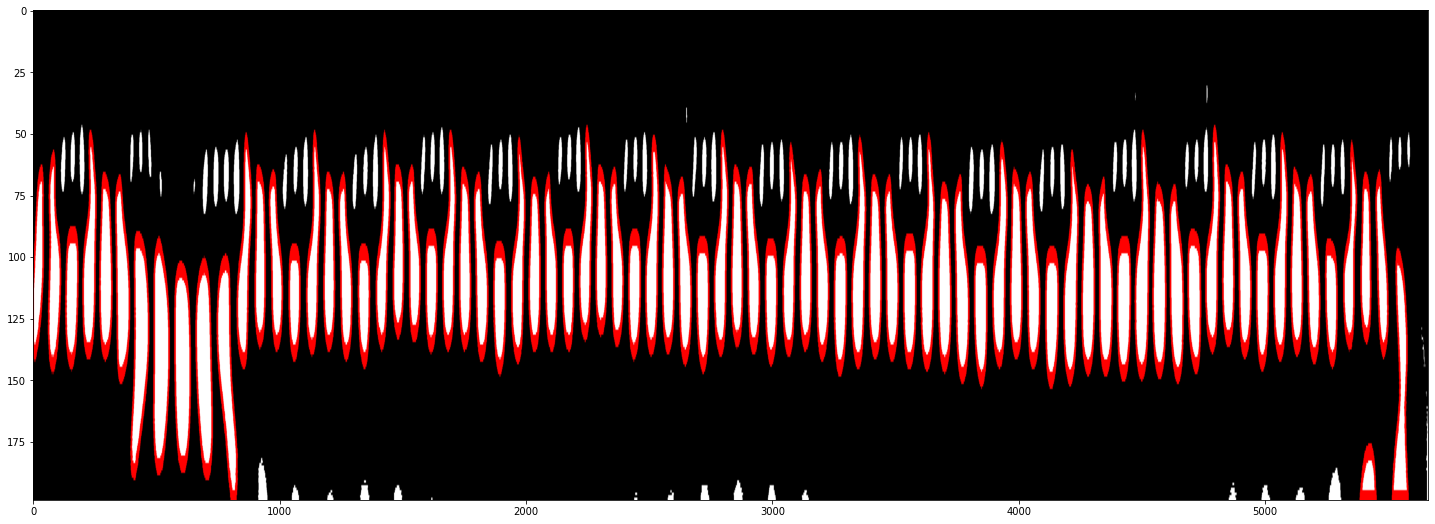

In [598]:
power_20perc = np.percentile(power, 80)
# power_binary = np.zeros(shape=power.shape)
# power_binary[np.where(power>power_20perc)]=255
ret, thresh_img = cv.threshold(power, power_20perc, 255, cv.THRESH_BINARY)
thresh_img = thresh_img.astype('uint8')

contours, hierarchy = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
area = [cv.contourArea(cnt) for cnt in contours]
area_thresh = np.percentile(area, 90)*0.3
contours_np = np.array(contours)
area_np = np.array(area)
large_contours = contours_np[np.where(area_np>area_thresh)]
print('number of detected contours = {}'.format(round(large_contours.shape[0]/4, 0)))

######### Plot
f, ax = plt.subplots(figsize=(25,10))
im = np.expand_dims(thresh_img.copy(), axis=2).repeat(3, axis=2) 
for k, _ in enumerate(large_contours):
    im = cv.drawContours(im, large_contours, k, (255, 0, 0), 6)
plt.imshow(im, aspect=10)
plt.show()

## Lift in subject 11

In [599]:
label = 'lift'
sub = 11
sig = filt_noNA_dict[sub][filt_noNA_dict[sub].label==label].Y.values

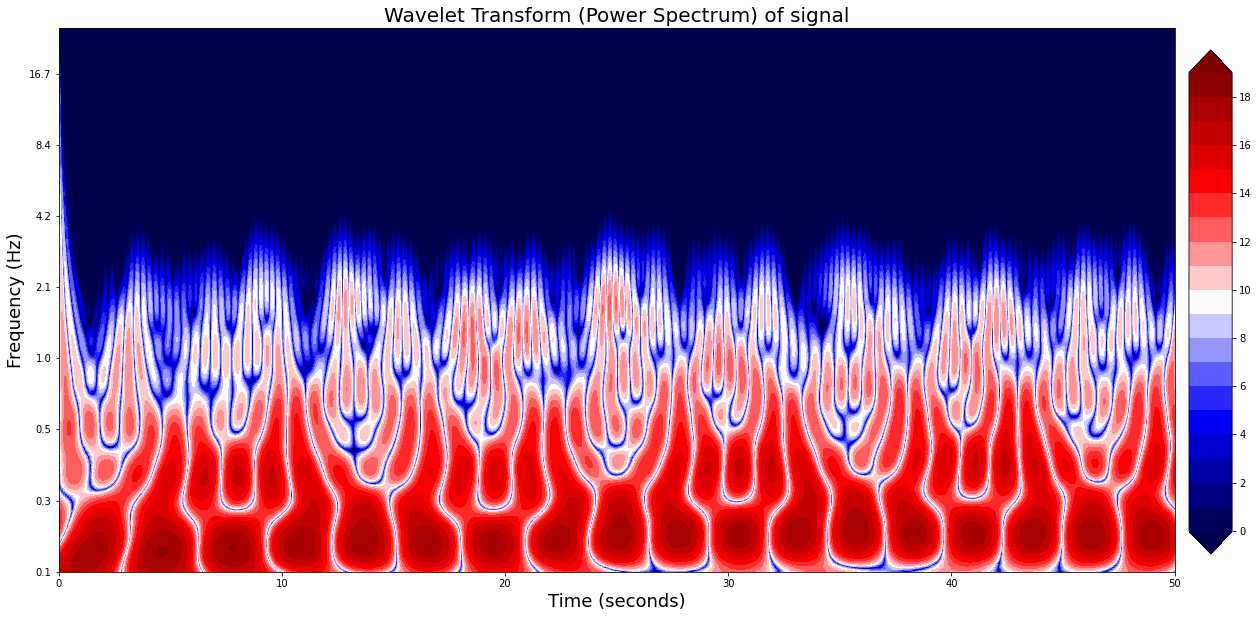

In [600]:
SR=1/32
time = np.arange(0, sig.shape[0]) * SR
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2
contourlevels = np.arange(0, 20)

############################### Plot
f, ax = plt.subplots(figsize=(20, 10))
im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=plt.cm.seismic)# np.log2(power)
ax.set_title('Wavelet Transform (Power Spectrum) of signal', fontsize=20)
ax.set_ylabel('Frequency (Hz)', fontsize=18)
ax.set_xlabel('Time (seconds)', fontsize=18)
cbar_ax = f.add_axes([0.91, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax, orientation="vertical")
yticks = np.arange(np.log2(frequencies).min(), np.log2(frequencies).max())
ax.set_yticks(yticks)
ax.set_yticklabels(np.round(2**(yticks), 1))
ax.set_xlim([0, 50])
plt.show()

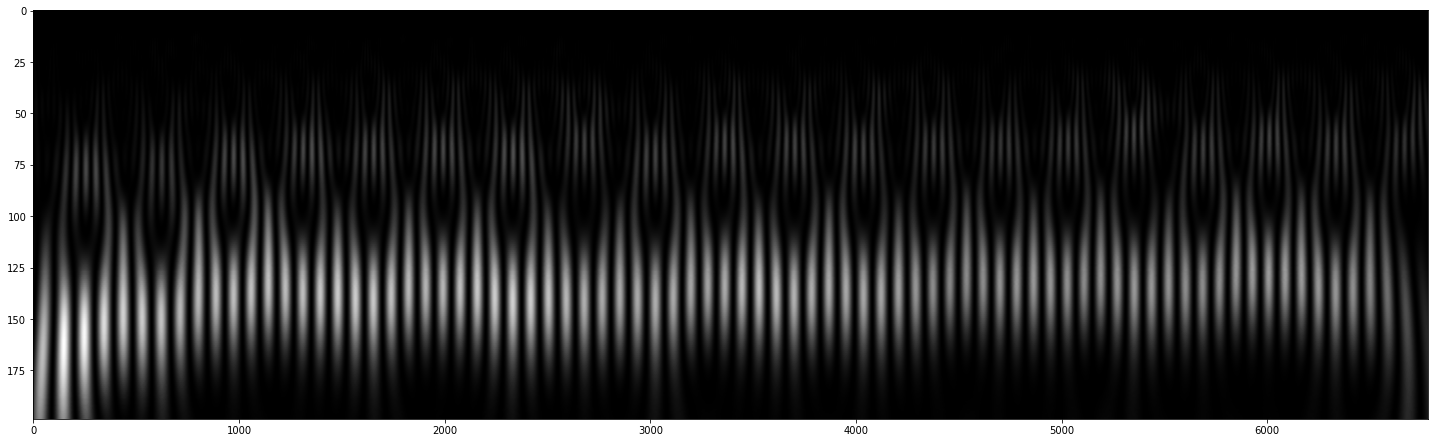

In [601]:
f, ax = plt.subplots(1, figsize=(25,10))
ax.imshow(power, cmap='gray', aspect=10)
plt.show()

number of detected contours = 20.0


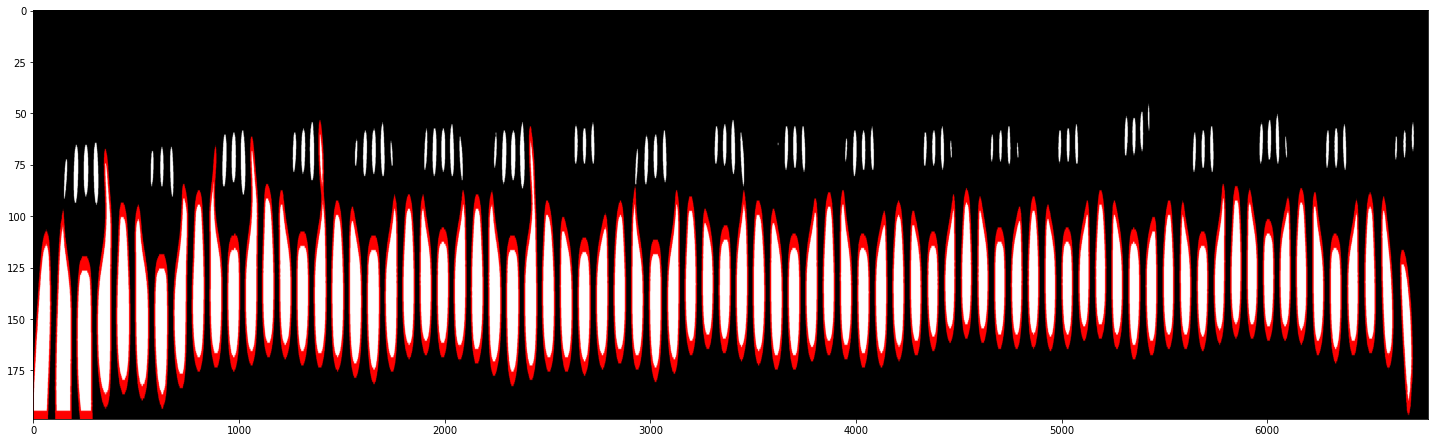

In [603]:
power_20perc = np.percentile(power, 80)
# power_binary = np.zeros(shape=power.shape)
# power_binary[np.where(power>power_20perc)]=255
ret, thresh_img = cv.threshold(power, power_20perc, 255, cv.THRESH_BINARY)
thresh_img = thresh_img.astype('uint8')

contours, hierarchy = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
area = [cv.contourArea(cnt) for cnt in contours]
area_thresh = np.percentile(area, 90)*0.3
contours_np = np.array(contours)
area_np = np.array(area)
large_contours = contours_np[np.where(area_np>area_thresh)]
print('number of detected contours = {}'.format(round(large_contours.shape[0]/4, 0)))

######### Plot
f, ax = plt.subplots(figsize=(25,10))
im = np.expand_dims(thresh_img.copy(), axis=2).repeat(3, axis=2) 
for k, _ in enumerate(large_contours):
    im = cv.drawContours(im, large_contours, k, (255, 0, 0), 6)
plt.imshow(im, aspect=10)
plt.show()

## Lift in subject 12

In [604]:
label = 'lift'
sub = 12
sig = filt_noNA_dict[sub][filt_noNA_dict[sub].label==label].Y.values

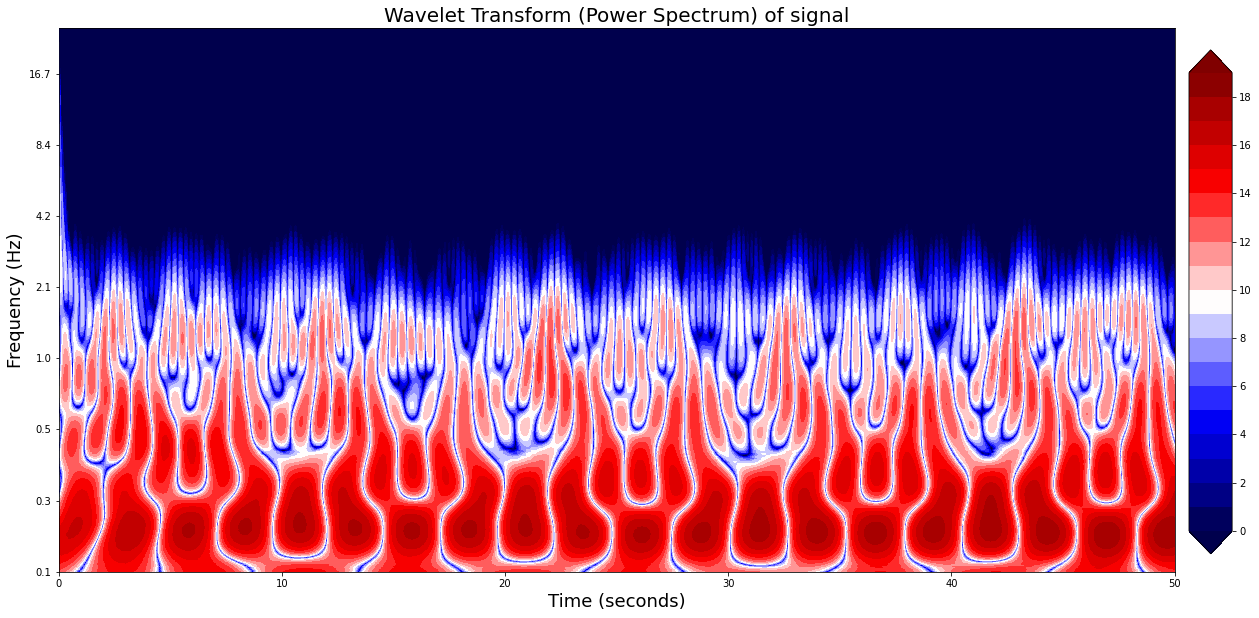

In [605]:
SR=1/32
time = np.arange(0, sig.shape[0]) * SR
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2
contourlevels = np.arange(0, 20)

############################### Plot
f, ax = plt.subplots(figsize=(20, 10))
im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=plt.cm.seismic)# np.log2(power)
ax.set_title('Wavelet Transform (Power Spectrum) of signal', fontsize=20)
ax.set_ylabel('Frequency (Hz)', fontsize=18)
ax.set_xlabel('Time (seconds)', fontsize=18)
cbar_ax = f.add_axes([0.91, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax, orientation="vertical")
yticks = np.arange(np.log2(frequencies).min(), np.log2(frequencies).max())
ax.set_yticks(yticks)
ax.set_yticklabels(np.round(2**(yticks), 1))
ax.set_xlim([0, 50])
plt.show()

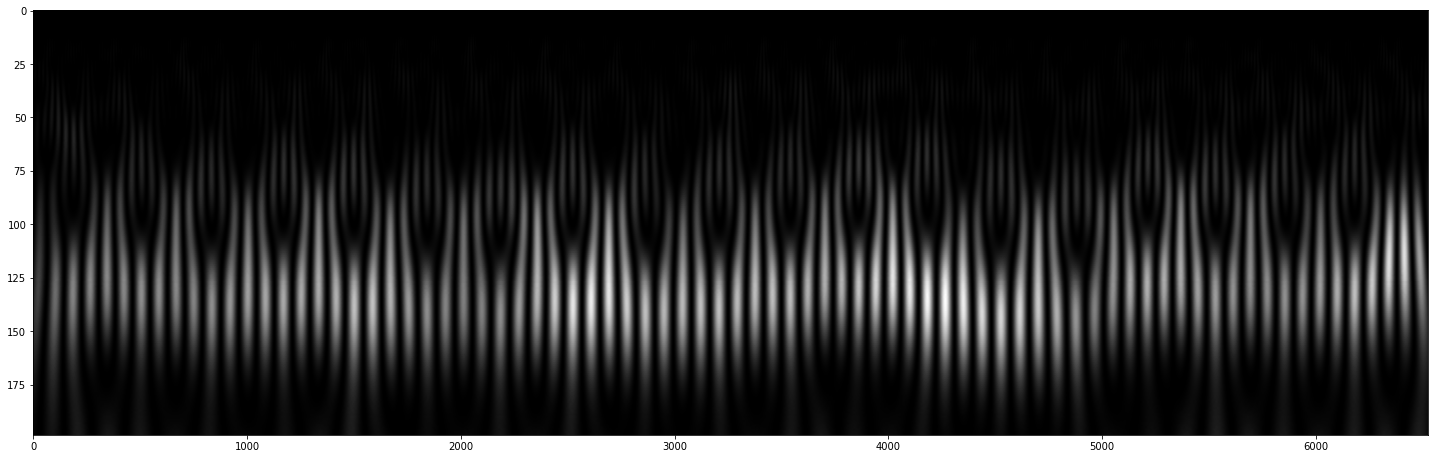

In [606]:
f, ax = plt.subplots(1, figsize=(25,10))
ax.imshow(power, cmap='gray', aspect=10)
plt.show()

number of detected contours = 20.0


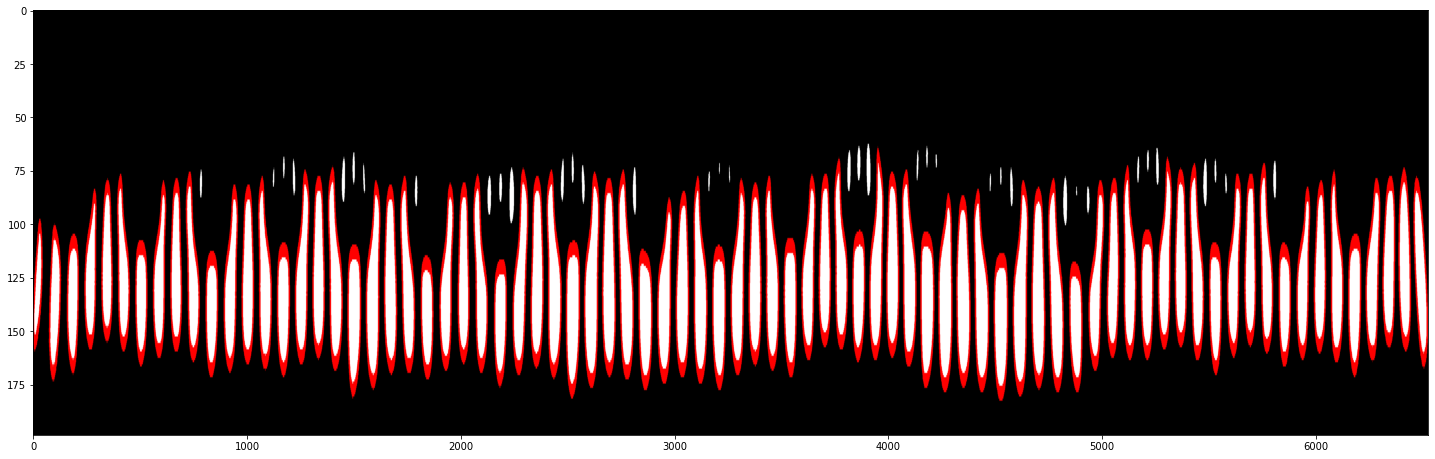

In [608]:
power_20perc = np.percentile(power, 80)
# power_binary = np.zeros(shape=power.shape)
# power_binary[np.where(power>power_20perc)]=255
ret, thresh_img = cv.threshold(power, power_20perc, 255, cv.THRESH_BINARY)
thresh_img = thresh_img.astype('uint8')

contours, hierarchy = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
area = [cv.contourArea(cnt) for cnt in contours]
area_thresh = np.percentile(area, 90)*0.3
contours_np = np.array(contours)
area_np = np.array(area)
large_contours = contours_np[np.where(area_np>area_thresh)]
print('number of detected contours = {}'.format(round(large_contours.shape[0]/4, 0)))

######### Plot
f, ax = plt.subplots(figsize=(25,10))
im = np.expand_dims(thresh_img.copy(), axis=2).repeat(3, axis=2) 
for k, _ in enumerate(large_contours):
    im = cv.drawContours(im, large_contours, k, (255, 0, 0), 6)
plt.imshow(im, aspect=10)
plt.show()

## Lift in subject 14

In [610]:
label = 'lift'
sub = 13
sig = filt_noNA_dict[sub][filt_noNA_dict[sub].label==label].Y.values

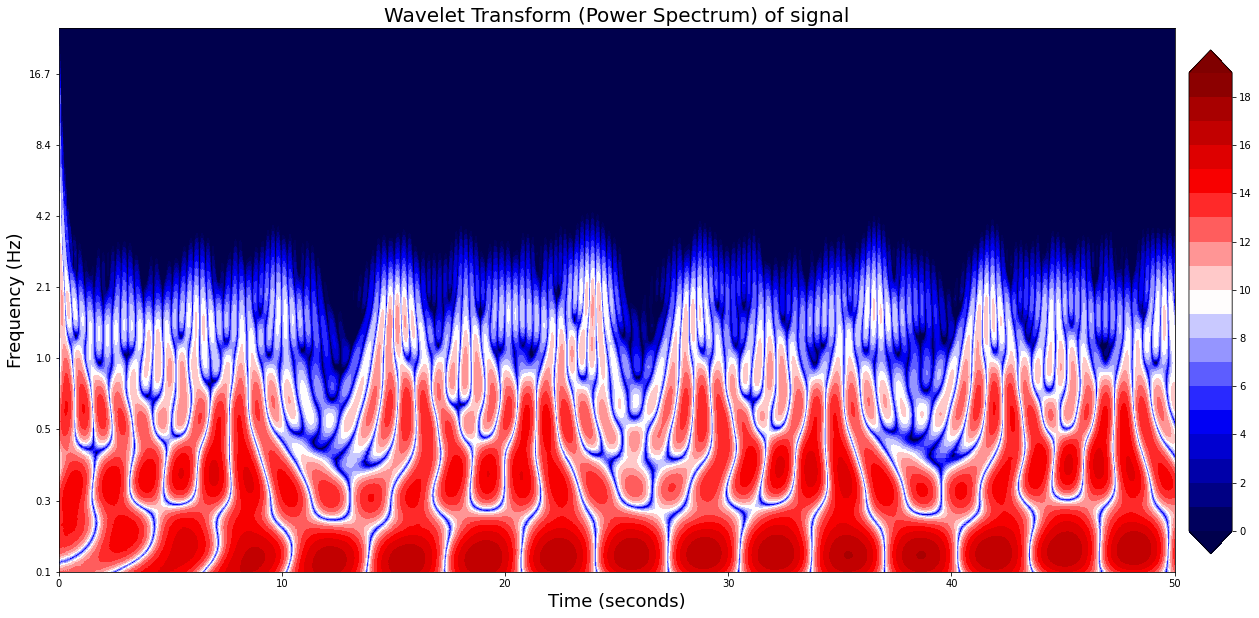

In [615]:
SR=1/32
time = np.arange(0, sig.shape[0]) * SR
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2
contourlevels = np.arange(0, 20)

############################### Plot
f, ax = plt.subplots(figsize=(20, 10))
im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=plt.cm.seismic)# np.log2(power)
ax.set_title('Wavelet Transform (Power Spectrum) of signal', fontsize=20)
ax.set_ylabel('Frequency (Hz)', fontsize=18)
ax.set_xlabel('Time (seconds)', fontsize=18)
cbar_ax = f.add_axes([0.91, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax, orientation="vertical")
yticks = np.arange(np.log2(frequencies).min(), np.log2(frequencies).max())
ax.set_yticks(yticks)
ax.set_yticklabels(np.round(2**(yticks), 1))
ax.set_xlim([0, 50])
plt.show()

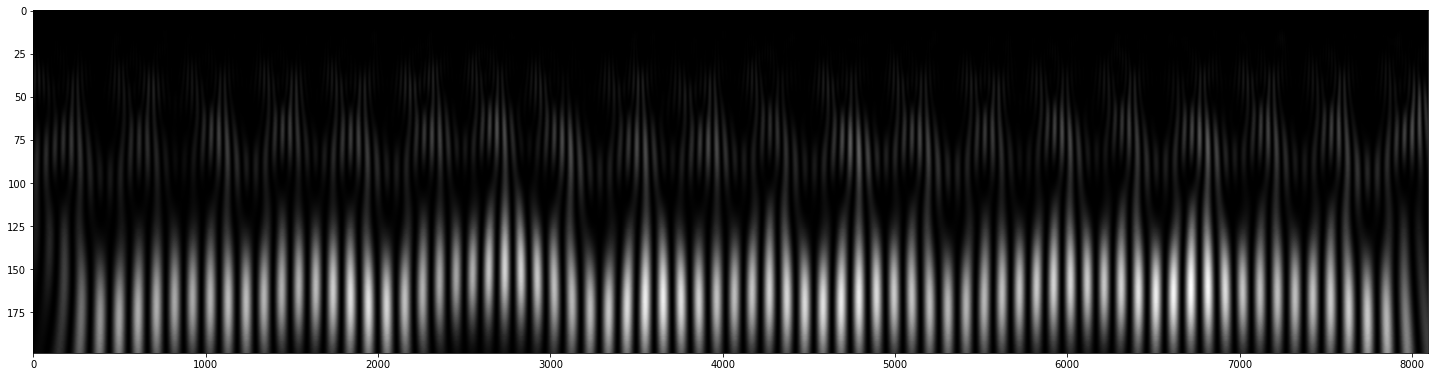

In [616]:
f, ax = plt.subplots(1, figsize=(25,10))
ax.imshow(power, cmap='gray', aspect=10)
plt.show()

number of detected contours = 19.0


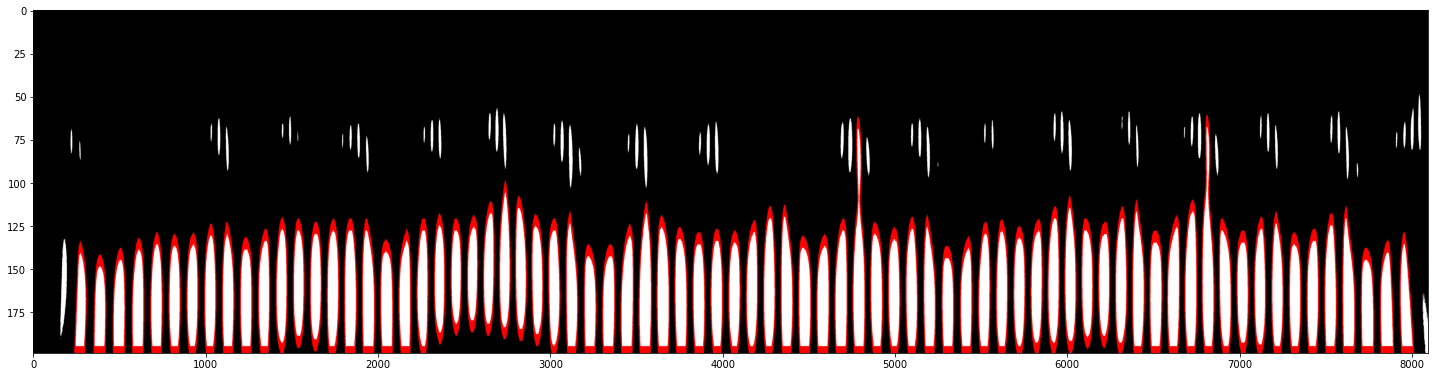

In [617]:
power_20perc = np.percentile(power, 80)
# power_binary = np.zeros(shape=power.shape)
# power_binary[np.where(power>power_20perc)]=255
ret, thresh_img = cv.threshold(power, power_20perc, 255, cv.THRESH_BINARY)
thresh_img = thresh_img.astype('uint8')

contours, hierarchy = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
area = [cv.contourArea(cnt) for cnt in contours]
area_thresh = np.percentile(area, 90)*0.3
contours_np = np.array(contours)
area_np = np.array(area)
large_contours = contours_np[np.where(area_np>area_thresh)]
print('number of detected contours = {}'.format(round(large_contours.shape[0]/4, 0)))

######### Plot
f, ax = plt.subplots(figsize=(25,10))
im = np.expand_dims(thresh_img.copy(), axis=2).repeat(3, axis=2) 
for k, _ in enumerate(large_contours):
    im = cv.drawContours(im, large_contours, k, (255, 0, 0), 6)
plt.imshow(im, aspect=10)
plt.show()

## Lift in subject 14

In [614]:
label = 'lift'
sub = 14
sig = filt_noNA_dict[sub][filt_noNA_dict[sub].label==label].Y.values

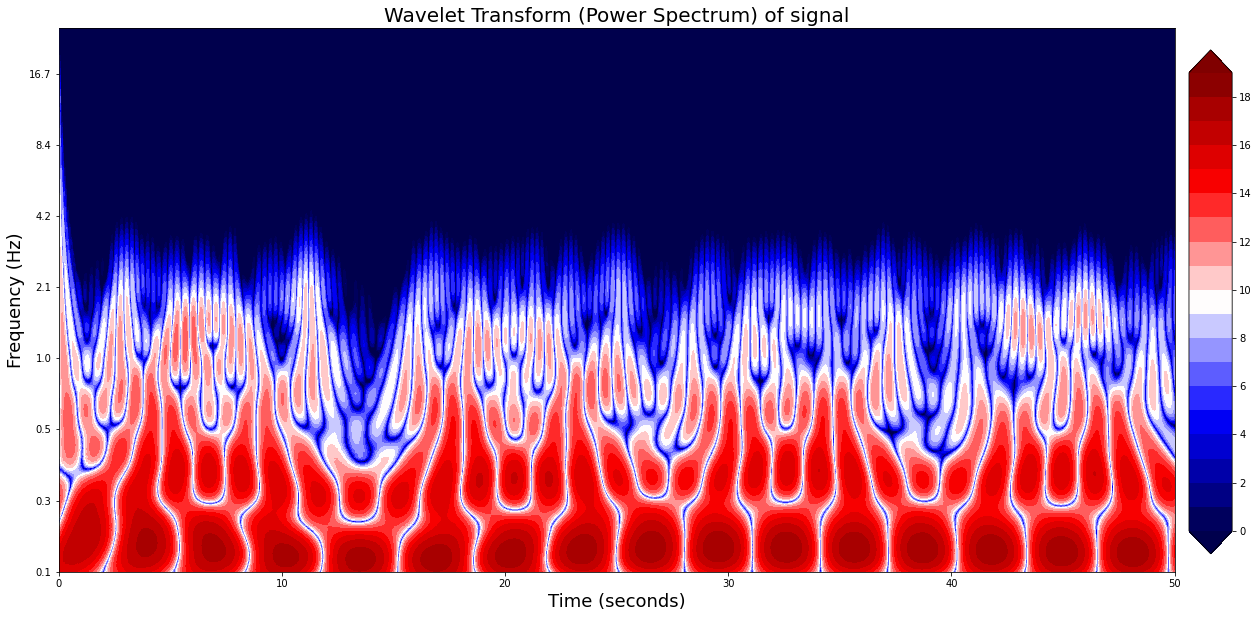

In [611]:
SR=1/32
time = np.arange(0, sig.shape[0]) * SR
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2
contourlevels = np.arange(0, 20)

############################### Plot
f, ax = plt.subplots(figsize=(20, 10))
im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=plt.cm.seismic)# np.log2(power)
ax.set_title('Wavelet Transform (Power Spectrum) of signal', fontsize=20)
ax.set_ylabel('Frequency (Hz)', fontsize=18)
ax.set_xlabel('Time (seconds)', fontsize=18)
cbar_ax = f.add_axes([0.91, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax, orientation="vertical")
yticks = np.arange(np.log2(frequencies).min(), np.log2(frequencies).max())
ax.set_yticks(yticks)
ax.set_yticklabels(np.round(2**(yticks), 1))
ax.set_xlim([0, 50])
plt.show()

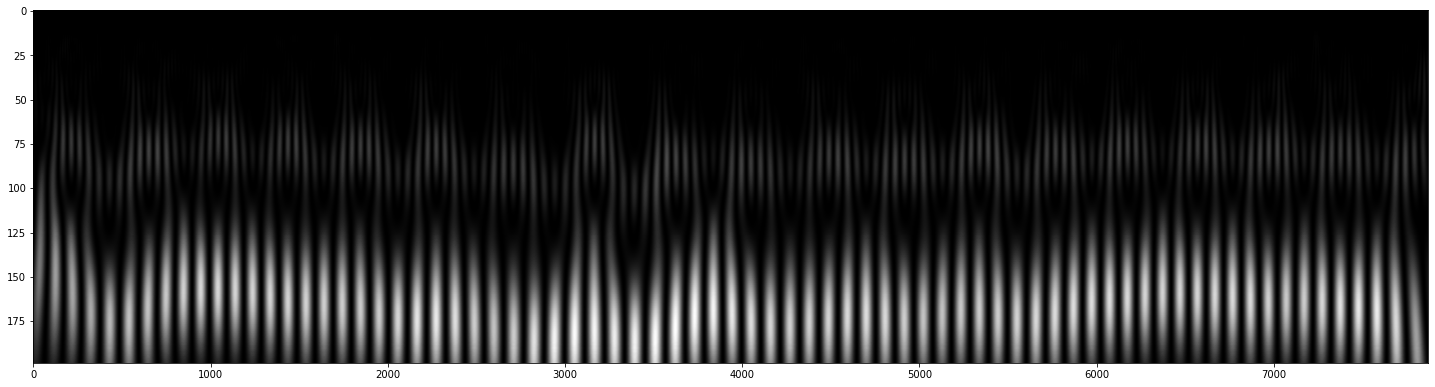

In [612]:
f, ax = plt.subplots(1, figsize=(25,10))
ax.imshow(power, cmap='gray', aspect=10)
plt.show()

number of detected contours = 19.0


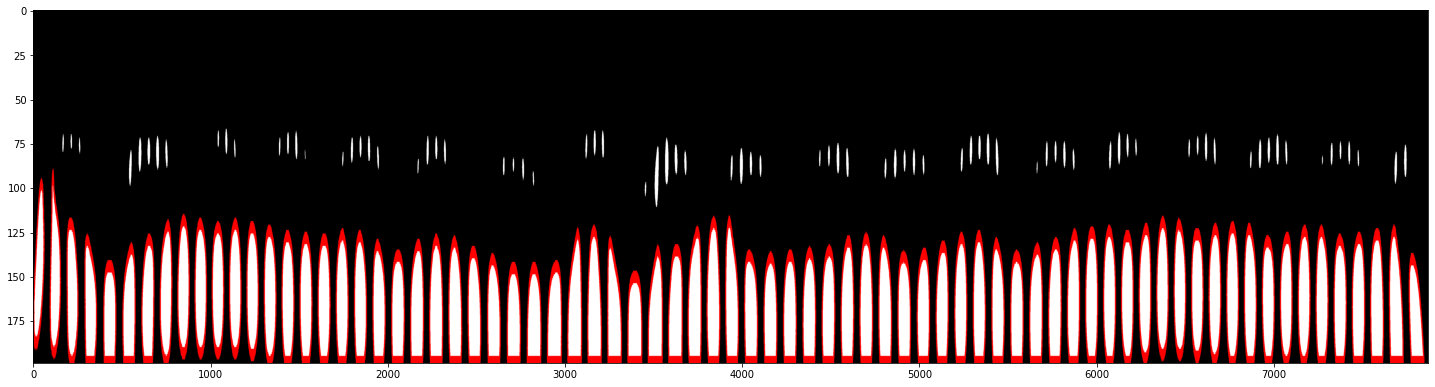

In [613]:
power_20perc = np.percentile(power, 80)
# power_binary = np.zeros(shape=power.shape)
# power_binary[np.where(power>power_20perc)]=255
ret, thresh_img = cv.threshold(power, power_20perc, 255, cv.THRESH_BINARY)
thresh_img = thresh_img.astype('uint8')

contours, hierarchy = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
area = [cv.contourArea(cnt) for cnt in contours]
area_thresh = np.percentile(area, 90)*0.3
contours_np = np.array(contours)
area_np = np.array(area)
large_contours = contours_np[np.where(area_np>area_thresh)]
print('number of detected contours = {}'.format(round(large_contours.shape[0]/4, 0)))

######### Plot
f, ax = plt.subplots(figsize=(25,10))
im = np.expand_dims(thresh_img.copy(), axis=2).repeat(3, axis=2) 
for k, _ in enumerate(large_contours):
    im = cv.drawContours(im, large_contours, k, (255, 0, 0), 6)
plt.imshow(im, aspect=10)
plt.show()

## Lift in subject 15

In [618]:
label = 'lift'
sub = 15
sig = filt_noNA_dict[sub][filt_noNA_dict[sub].label==label].Y.values

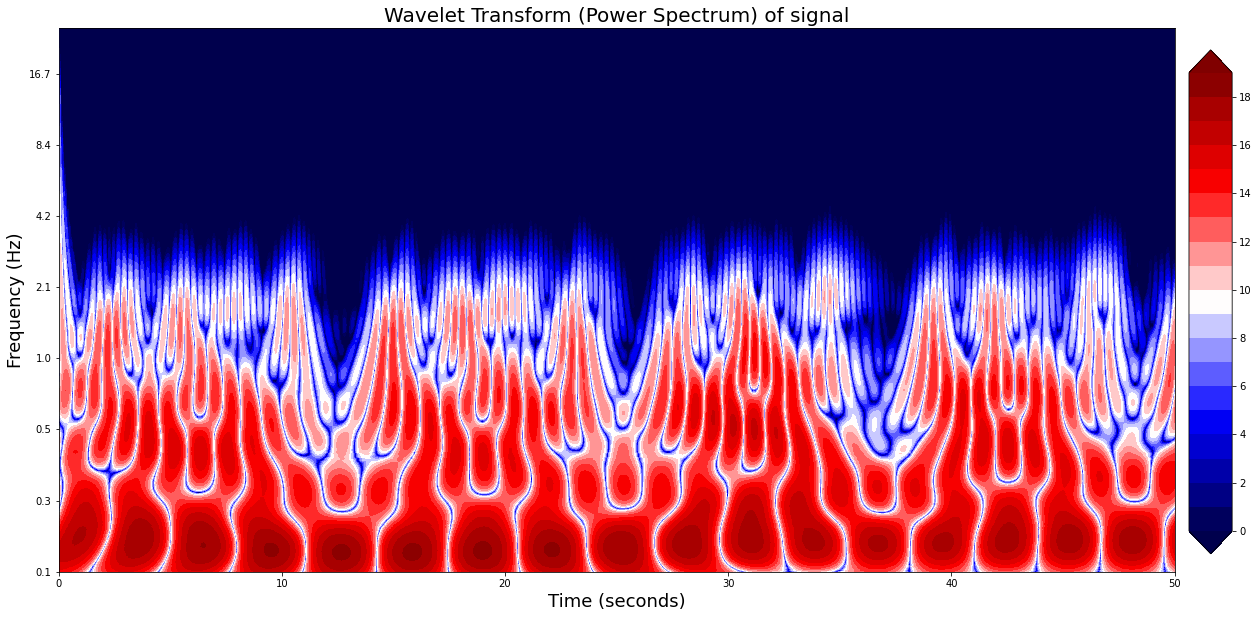

In [619]:
SR=1/32
time = np.arange(0, sig.shape[0]) * SR
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2
contourlevels = np.arange(0, 20)

############################### Plot
f, ax = plt.subplots(figsize=(20, 10))
im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=plt.cm.seismic)# np.log2(power)
ax.set_title('Wavelet Transform (Power Spectrum) of signal', fontsize=20)
ax.set_ylabel('Frequency (Hz)', fontsize=18)
ax.set_xlabel('Time (seconds)', fontsize=18)
cbar_ax = f.add_axes([0.91, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax, orientation="vertical")
yticks = np.arange(np.log2(frequencies).min(), np.log2(frequencies).max())
ax.set_yticks(yticks)
ax.set_yticklabels(np.round(2**(yticks), 1))
ax.set_xlim([0, 50])
plt.show()

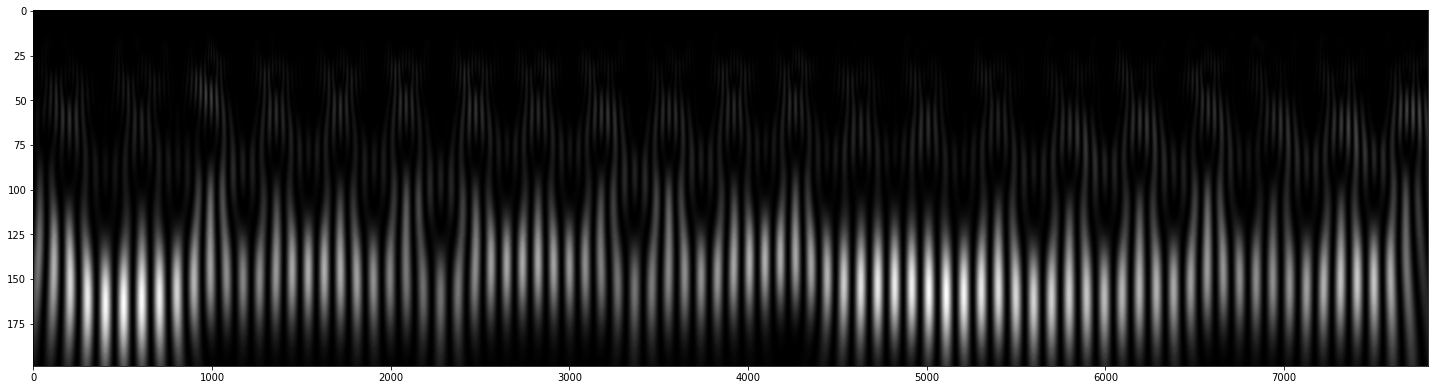

In [620]:
f, ax = plt.subplots(1, figsize=(25,10))
ax.imshow(power, cmap='gray', aspect=10)
plt.show()

number of detected contours = 21.0


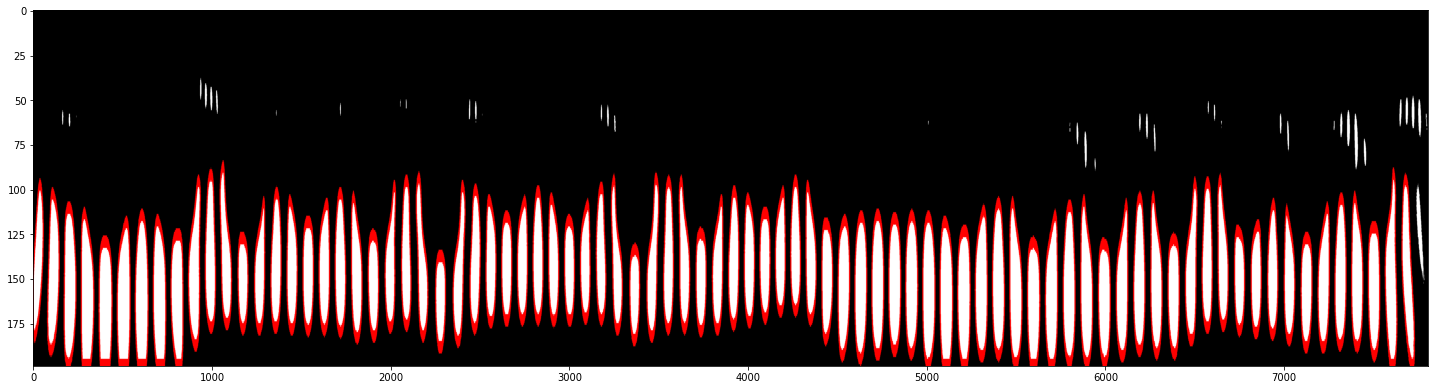

In [621]:
power_20perc = np.percentile(power, 80)
# power_binary = np.zeros(shape=power.shape)
# power_binary[np.where(power>power_20perc)]=255
ret, thresh_img = cv.threshold(power, power_20perc, 255, cv.THRESH_BINARY)
thresh_img = thresh_img.astype('uint8')

contours, hierarchy = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
area = [cv.contourArea(cnt) for cnt in contours]
area_thresh = np.percentile(area, 90)*0.3
contours_np = np.array(contours)
area_np = np.array(area)
large_contours = contours_np[np.where(area_np>area_thresh)]
print('number of detected contours = {}'.format(round(large_contours.shape[0]/4, 0)))

######### Plot
f, ax = plt.subplots(figsize=(25,10))
im = np.expand_dims(thresh_img.copy(), axis=2).repeat(3, axis=2) 
for k, _ in enumerate(large_contours):
    im = cv.drawContours(im, large_contours, k, (255, 0, 0), 6)
plt.imshow(im, aspect=10)
plt.show()

## Lift in subject 16

In [622]:
label = 'lift'
sub = 16
sig = filt_noNA_dict[sub][filt_noNA_dict[sub].label==label].Y.values

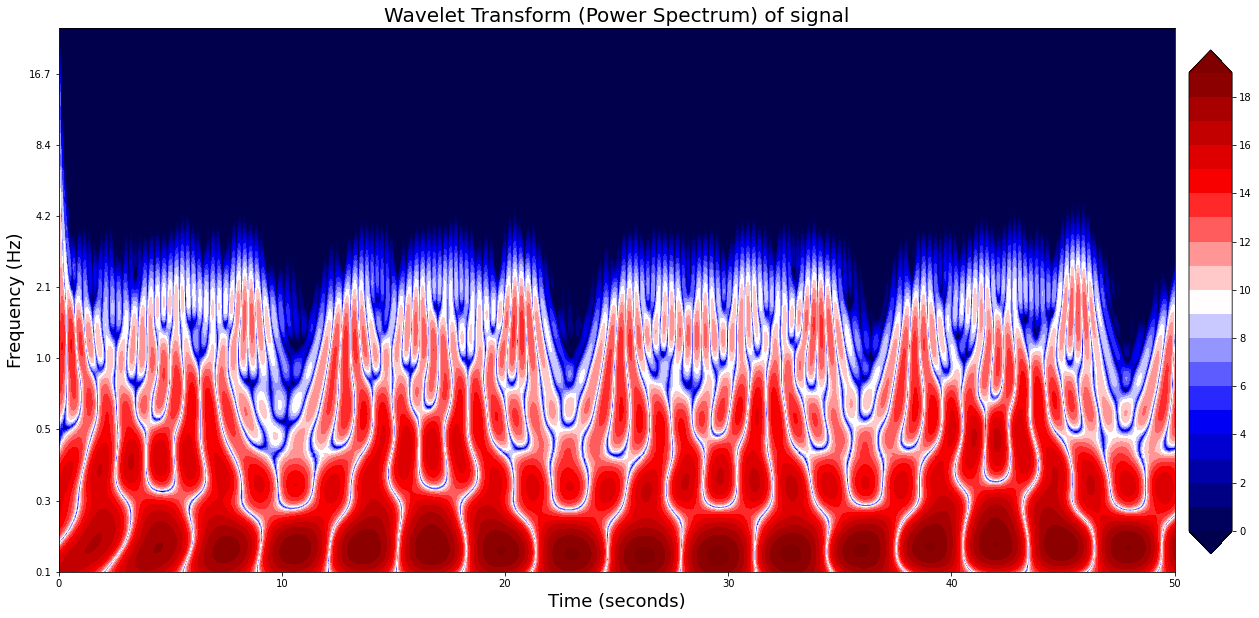

In [623]:
SR=1/32
time = np.arange(0, sig.shape[0]) * SR
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2
contourlevels = np.arange(0, 20)

############################### Plot
f, ax = plt.subplots(figsize=(20, 10))
im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=plt.cm.seismic)# np.log2(power)
ax.set_title('Wavelet Transform (Power Spectrum) of signal', fontsize=20)
ax.set_ylabel('Frequency (Hz)', fontsize=18)
ax.set_xlabel('Time (seconds)', fontsize=18)
cbar_ax = f.add_axes([0.91, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax, orientation="vertical")
yticks = np.arange(np.log2(frequencies).min(), np.log2(frequencies).max())
ax.set_yticks(yticks)
ax.set_yticklabels(np.round(2**(yticks), 1))
ax.set_xlim([0, 50])
plt.show()

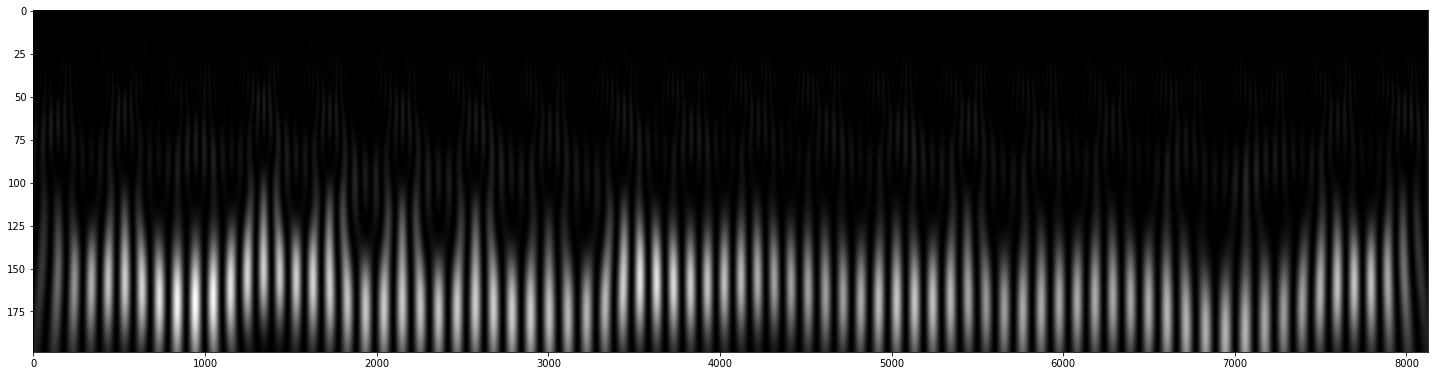

In [624]:
f, ax = plt.subplots(1, figsize=(25,10))
ax.imshow(power, cmap='gray', aspect=10)
plt.show()

number of detected contours = 19.0


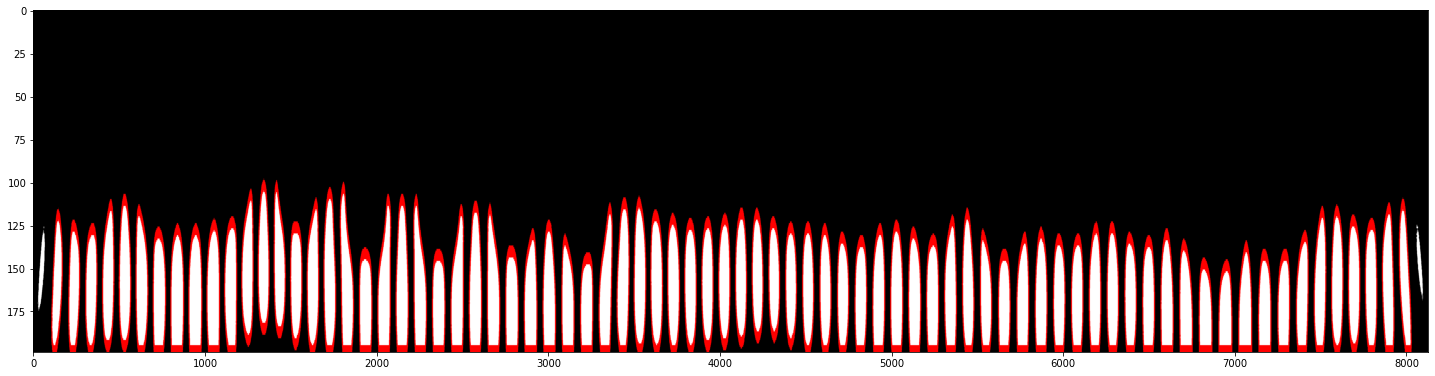

In [625]:
power_20perc = np.percentile(power, 80)
# power_binary = np.zeros(shape=power.shape)
# power_binary[np.where(power>power_20perc)]=255
ret, thresh_img = cv.threshold(power, power_20perc, 255, cv.THRESH_BINARY)
thresh_img = thresh_img.astype('uint8')

contours, hierarchy = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
area = [cv.contourArea(cnt) for cnt in contours]
area_thresh = np.percentile(area, 90)*0.3
contours_np = np.array(contours)
area_np = np.array(area)
large_contours = contours_np[np.where(area_np>area_thresh)]
print('number of detected contours = {}'.format(round(large_contours.shape[0]/4, 0)))

######### Plot
f, ax = plt.subplots(figsize=(25,10))
im = np.expand_dims(thresh_img.copy(), axis=2).repeat(3, axis=2) 
for k, _ in enumerate(large_contours):
    im = cv.drawContours(im, large_contours, k, (255, 0, 0), 6)
plt.imshow(im, aspect=10)
plt.show()

## Lift in subject 17

In [626]:
label = 'lift'
sub = 17
sig = filt_noNA_dict[sub][filt_noNA_dict[sub].label==label].Y.values

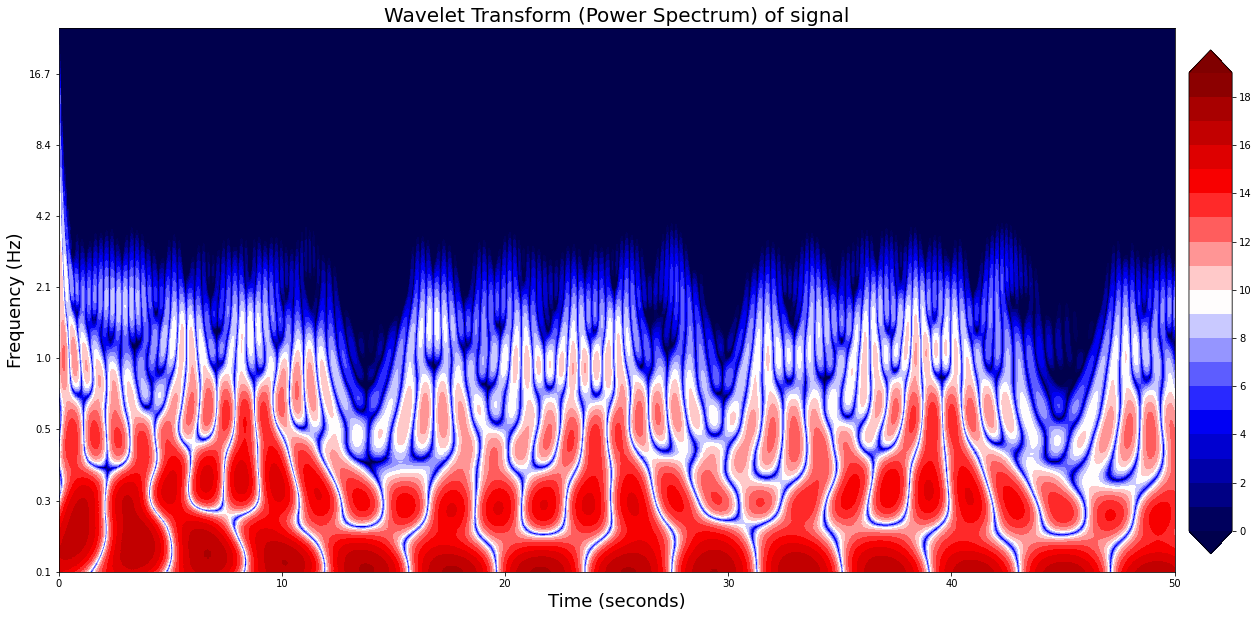

In [627]:
SR=1/32
time = np.arange(0, sig.shape[0]) * SR
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2
contourlevels = np.arange(0, 20)

############################### Plot
f, ax = plt.subplots(figsize=(20, 10))
im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=plt.cm.seismic)# np.log2(power)
ax.set_title('Wavelet Transform (Power Spectrum) of signal', fontsize=20)
ax.set_ylabel('Frequency (Hz)', fontsize=18)
ax.set_xlabel('Time (seconds)', fontsize=18)
cbar_ax = f.add_axes([0.91, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax, orientation="vertical")
yticks = np.arange(np.log2(frequencies).min(), np.log2(frequencies).max())
ax.set_yticks(yticks)
ax.set_yticklabels(np.round(2**(yticks), 1))
ax.set_xlim([0, 50])
plt.show()

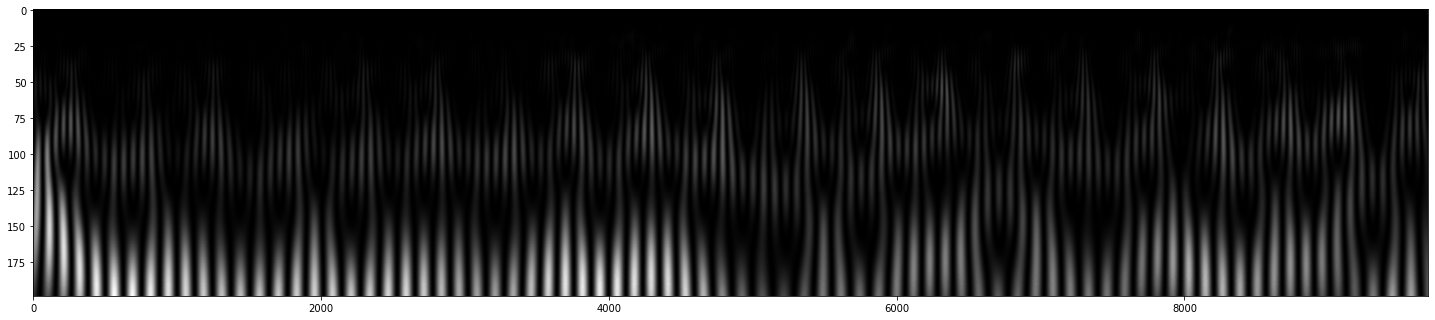

In [628]:
f, ax = plt.subplots(1, figsize=(25,10))
ax.imshow(power, cmap='gray', aspect=10)
plt.show()

number of detected contours = 21.0


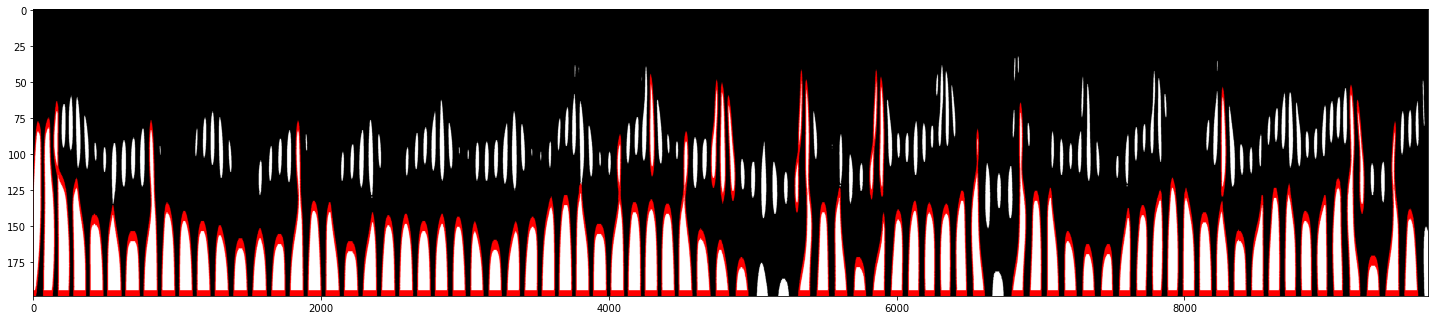

In [629]:
power_20perc = np.percentile(power, 80)
# power_binary = np.zeros(shape=power.shape)
# power_binary[np.where(power>power_20perc)]=255
ret, thresh_img = cv.threshold(power, power_20perc, 255, cv.THRESH_BINARY)
thresh_img = thresh_img.astype('uint8')

contours, hierarchy = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
area = [cv.contourArea(cnt) for cnt in contours]
area_thresh = np.percentile(area, 90)*0.3
contours_np = np.array(contours)
area_np = np.array(area)
large_contours = contours_np[np.where(area_np>area_thresh)]
print('number of detected contours = {}'.format(round(large_contours.shape[0]/4, 0)))

######### Plot
f, ax = plt.subplots(figsize=(25,10))
im = np.expand_dims(thresh_img.copy(), axis=2).repeat(3, axis=2) 
for k, _ in enumerate(large_contours):
    im = cv.drawContours(im, large_contours, k, (255, 0, 0), 6)
plt.imshow(im, aspect=10)
plt.show()

## Lift in subject 18

In [630]:
label = 'lift'
sub = 18
sig = filt_noNA_dict[sub][filt_noNA_dict[sub].label==label].Y.values

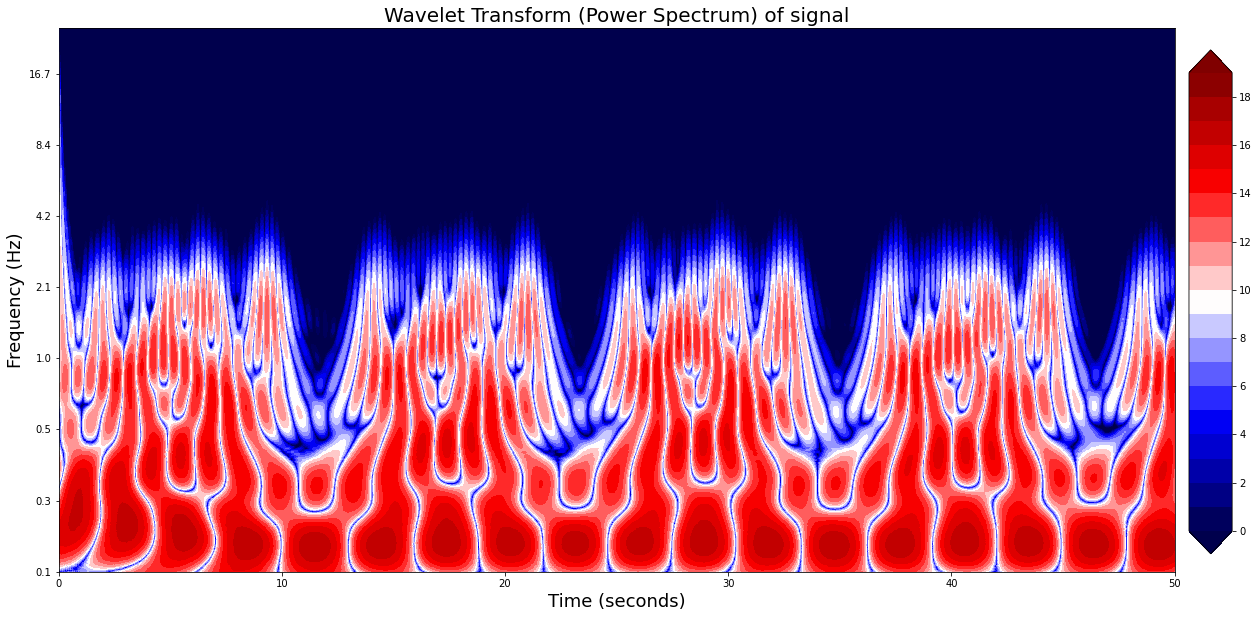

In [631]:
SR=1/32
time = np.arange(0, sig.shape[0]) * SR
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2
contourlevels = np.arange(0, 20)

############################### Plot
f, ax = plt.subplots(figsize=(20, 10))
im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=plt.cm.seismic)# np.log2(power)
ax.set_title('Wavelet Transform (Power Spectrum) of signal', fontsize=20)
ax.set_ylabel('Frequency (Hz)', fontsize=18)
ax.set_xlabel('Time (seconds)', fontsize=18)
cbar_ax = f.add_axes([0.91, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax, orientation="vertical")
yticks = np.arange(np.log2(frequencies).min(), np.log2(frequencies).max())
ax.set_yticks(yticks)
ax.set_yticklabels(np.round(2**(yticks), 1))
ax.set_xlim([0, 50])
plt.show()

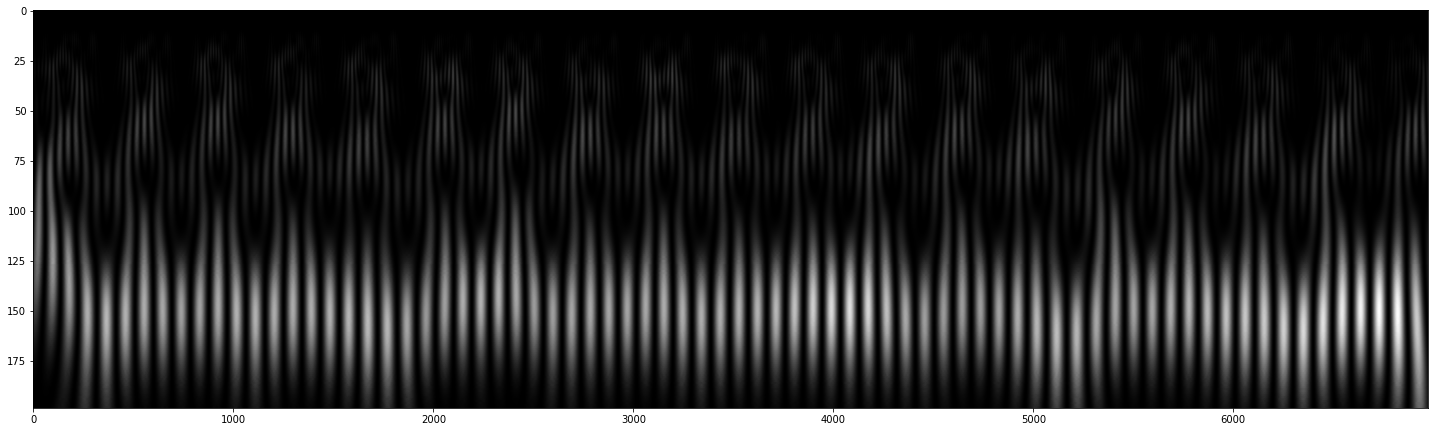

In [632]:
f, ax = plt.subplots(1, figsize=(25,10))
ax.imshow(power, cmap='gray', aspect=10)
plt.show()

number of detected contours = 19.0


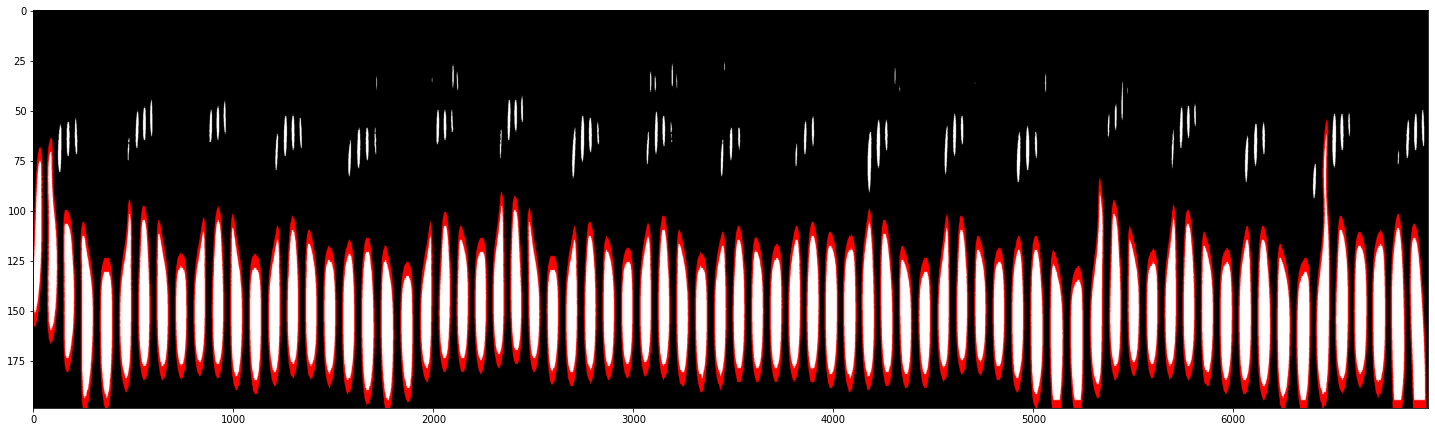

In [633]:
power_20perc = np.percentile(power, 80)
# power_binary = np.zeros(shape=power.shape)
# power_binary[np.where(power>power_20perc)]=255
ret, thresh_img = cv.threshold(power, power_20perc, 255, cv.THRESH_BINARY)
thresh_img = thresh_img.astype('uint8')

contours, hierarchy = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
area = [cv.contourArea(cnt) for cnt in contours]
area_thresh = np.percentile(area, 90)*0.3
contours_np = np.array(contours)
area_np = np.array(area)
large_contours = contours_np[np.where(area_np>area_thresh)]
print('number of detected contours = {}'.format(round(large_contours.shape[0]/4, 0)))

######### Plot
f, ax = plt.subplots(figsize=(25,10))
im = np.expand_dims(thresh_img.copy(), axis=2).repeat(3, axis=2) 
for k, _ in enumerate(large_contours):
    im = cv.drawContours(im, large_contours, k, (255, 0, 0), 6)
plt.imshow(im, aspect=10)
plt.show()

## Lift in subject 19

In [634]:
label = 'lift'
sub = 19
sig = filt_noNA_dict[sub][filt_noNA_dict[sub].label==label].Y.values

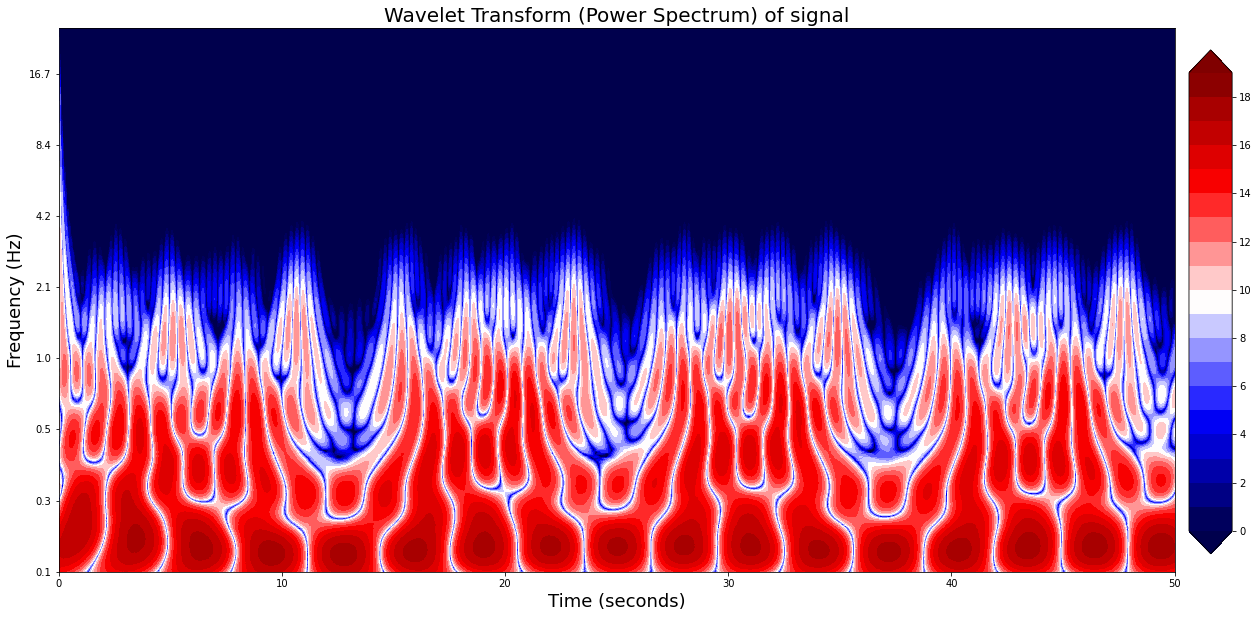

In [635]:
SR=1/32
time = np.arange(0, sig.shape[0]) * SR
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2
contourlevels = np.arange(0, 20)

############################### Plot
f, ax = plt.subplots(figsize=(20, 10))
im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=plt.cm.seismic)# np.log2(power)
ax.set_title('Wavelet Transform (Power Spectrum) of signal', fontsize=20)
ax.set_ylabel('Frequency (Hz)', fontsize=18)
ax.set_xlabel('Time (seconds)', fontsize=18)
cbar_ax = f.add_axes([0.91, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax, orientation="vertical")
yticks = np.arange(np.log2(frequencies).min(), np.log2(frequencies).max())
ax.set_yticks(yticks)
ax.set_yticklabels(np.round(2**(yticks), 1))
ax.set_xlim([0, 50])
plt.show()

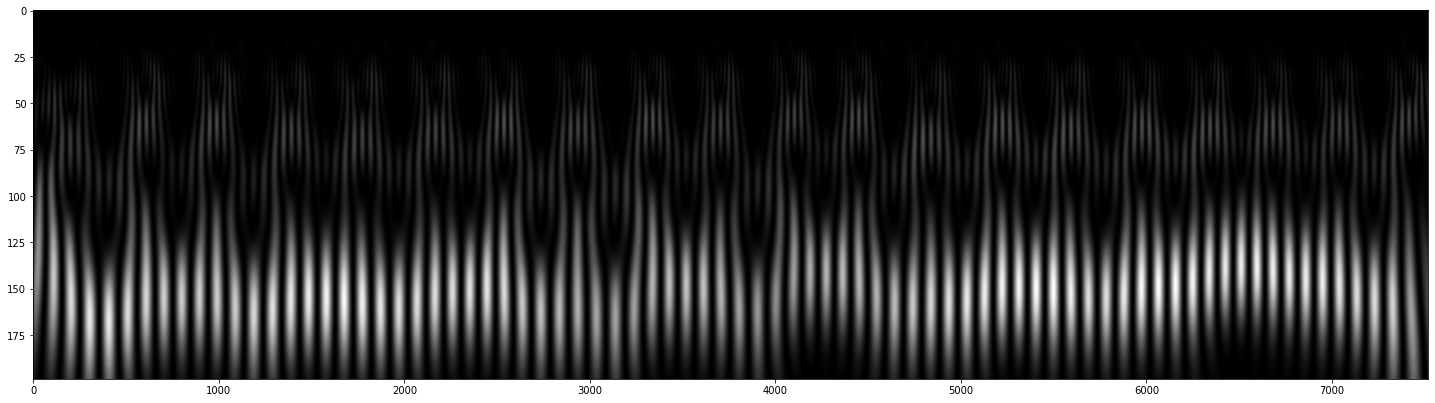

In [636]:
f, ax = plt.subplots(1, figsize=(25,10))
ax.imshow(power, cmap='gray', aspect=10)
plt.show()

number of detected contours = 20.0


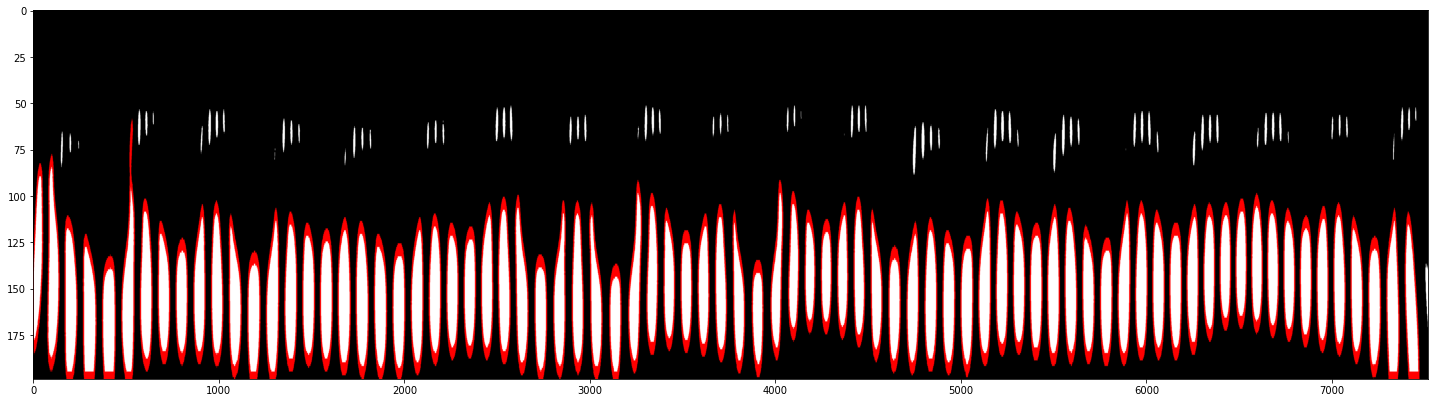

In [637]:
power_20perc = np.percentile(power, 80)
# power_binary = np.zeros(shape=power.shape)
# power_binary[np.where(power>power_20perc)]=255
ret, thresh_img = cv.threshold(power, power_20perc, 255, cv.THRESH_BINARY)
thresh_img = thresh_img.astype('uint8')

contours, hierarchy = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
area = [cv.contourArea(cnt) for cnt in contours]
area_thresh = np.percentile(area, 90)*0.3
contours_np = np.array(contours)
area_np = np.array(area)
large_contours = contours_np[np.where(area_np>area_thresh)]
print('number of detected contours = {}'.format(round(large_contours.shape[0]/4, 0)))

######### Plot
f, ax = plt.subplots(figsize=(25,10))
im = np.expand_dims(thresh_img.copy(), axis=2).repeat(3, axis=2) 
for k, _ in enumerate(large_contours):
    im = cv.drawContours(im, large_contours, k, (255, 0, 0), 6)
plt.imshow(im, aspect=10)
plt.show()

## Lift in subject 20

In [39]:
aa = filt_noNA_dict[37].reset_index().drop(columns='index')
aa[aa.label=='lift']

X          Y          Z        Mag label
24320 -52.261351 -46.145542  -0.631995  71.571509  lift
24321 -59.008736 -44.620512  -1.789806  75.732703  lift
24322 -66.492768 -44.025416  -2.012825  81.146719  lift
24323 -73.947306 -44.248323  -1.187267  87.131502  lift
24324 -80.553095 -45.109341   0.666112  92.908824  lift
...          ...        ...        ...        ...   ...
35259 -62.091098 -29.776554 -24.649741   71.23221  lift
35260 -61.822156 -32.319668 -22.156333  72.773336  lift
35261 -60.314131 -35.500533 -19.038688  74.101303  lift
35262 -57.473512 -39.187479 -15.321901  75.033014  lift
35263 -53.350433 -43.191502  -11.14357  75.432983  lift

[10944 rows x 5 columns]

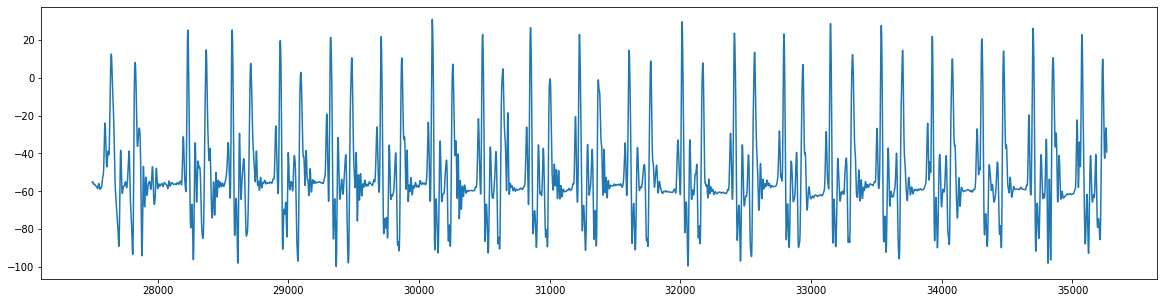

In [47]:
f, ax = plt.subplots(1, figsize=(20,5))
# ax.plot(filt_noNA_dict[37].iloc[50048:60991].Y)
# ax.plot(aa.iloc[24320:35263].Y)
ax.plot(aa.iloc[27500:35263].Y)

plt.show()

In [24]:
label = 'lift'
sub = 37
sig = filt_noNA_dict[sub][filt_noNA_dict[sub].label==label].Y.values

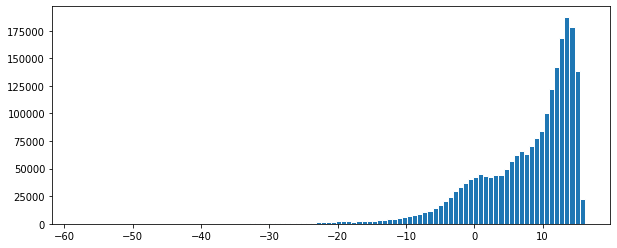

In [26]:
power_logscale = np.log2(power)
for_hist =power_logscale.flatten()
f, ax = plt.subplots(1,1, figsize=(10,4))
ax.hist(for_hist, bins=100, edgecolor='w')
plt.show()

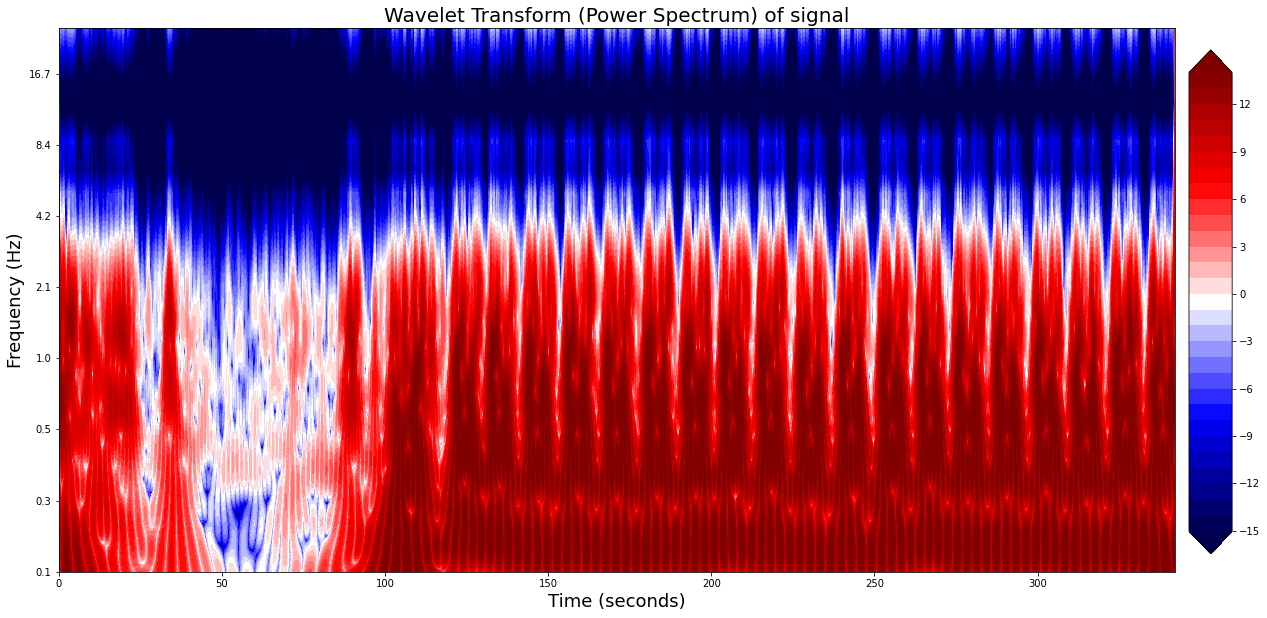

In [27]:
SR=1/32
time = np.arange(0, sig.shape[0]) * SR
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2
# contourlevels = np.arange(0, 20)
contourlevels = np.arange(-15, 15)

############################### Plot
f, ax = plt.subplots(figsize=(20, 10))
im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=plt.cm.seismic)# np.log2(power)
ax.set_title('Wavelet Transform (Power Spectrum) of signal', fontsize=20)
ax.set_ylabel('Frequency (Hz)', fontsize=18)
ax.set_xlabel('Time (seconds)', fontsize=18)
cbar_ax = f.add_axes([0.91, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax, orientation="vertical")
yticks = np.arange(np.log2(frequencies).min(), np.log2(frequencies).max())
ax.set_yticks(yticks)
ax.set_yticklabels(np.round(2**(yticks), 1))
# ax.set_xlim([0, 50])
plt.show()

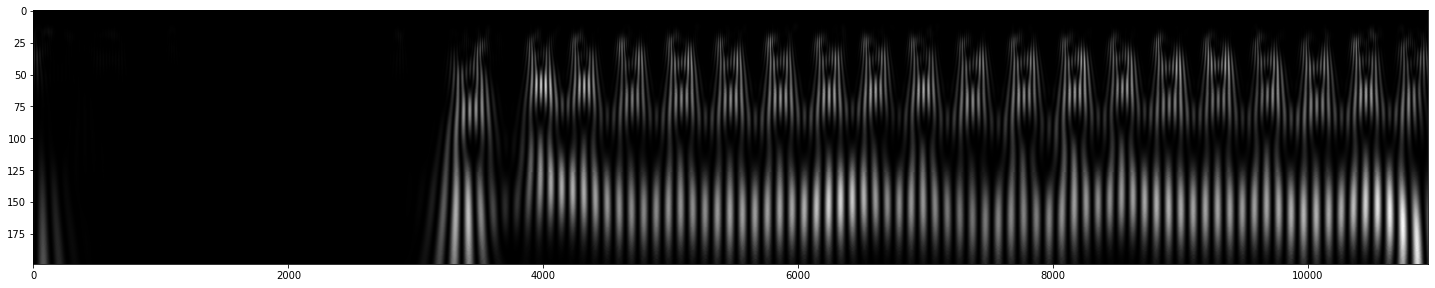

In [28]:
f, ax = plt.subplots(1, figsize=(25,10))
ax.imshow(power, cmap='gray', aspect=10)
plt.show()

In [ ]:
ret, thresh_img = cv.threshold(power, power_thresh, 255, cv.THRESH_BINARY)
thresh_img_ = thresh_img.astype('uint8')
thresh_img = thresh_img_[20:35,:]

number of detected contours = 20.0


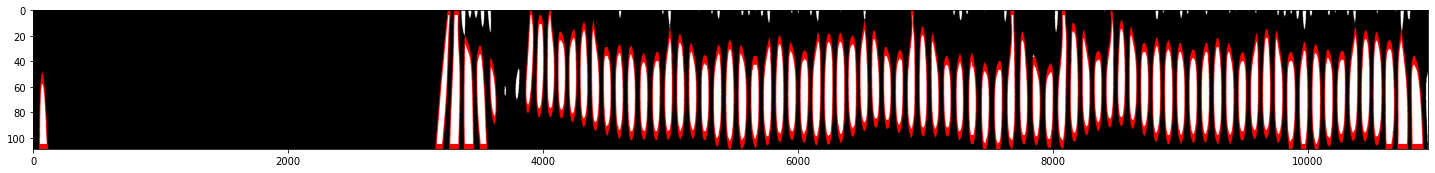

In [48]:
power_20perc = np.percentile(power, 80)
# power_binary = np.zeros(shape=power.shape)
# power_binary[np.where(power>power_20perc)]=255
ret, thresh_img = cv.threshold(power, power_20perc, 255, cv.THRESH_BINARY)
thresh_img_ = thresh_img.astype('uint8')
thresh_img = thresh_img_[90:,:]

contours, hierarchy = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
area = [cv.contourArea(cnt) for cnt in contours]
area_thresh = np.percentile(area, 90)*0.3
contours_np = np.array(contours)
area_np = np.array(area)
large_contours = contours_np[np.where(area_np>area_thresh)]
print('number of detected contours = {}'.format(round(large_contours.shape[0]/4, 0)))

######### Plot
f, ax = plt.subplots(figsize=(25,10))
im = np.expand_dims(thresh_img.copy(), axis=2).repeat(3, axis=2) 
for k, _ in enumerate(large_contours):
    im = cv.drawContours(im, large_contours, k, (255, 0, 0), 6)
plt.imshow(im, aspect=10)
plt.show()

# Count Number of Lifts in All Subjects

In [49]:
label = 'lift'
lift_count_dict = {}
for sub in filt_noNA_dict.keys():
    sig = filt_noNA_dict[sub][filt_noNA_dict[sub].label==label].Y.values
    
    scales = np.arange(1, 200)
    [coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
    power = (abs(coefficients)) ** 2

    power_20perc = np.percentile(power, 80)
    ret, thresh_img__ = cv.threshold(power, power_20perc, 255, cv.THRESH_BINARY)
    thresh_img_ = thresh_img__.astype('uint8')
    thresh_img = thresh_img_[90:,:]

    contours, hierarchy = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    area = [cv.contourArea(cnt) for cnt in contours]
    area_thresh = np.percentile(area, 90)*0.3
    contours_np = np.array(contours)
    area_np = np.array(area)
    large_contours = contours_np[np.where(area_np>area_thresh)]
    lift_count_dict[sub] = round(large_contours.shape[0]/4, 0)

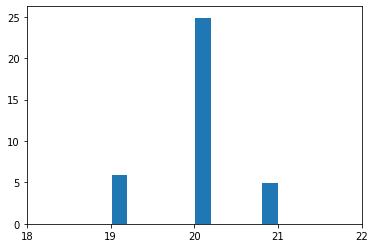

In [105]:
f, ax = plt.subplots(1)#, figsize=plt.figaspect(0.25))
ax.hist(lift_count_dict.values(), edgecolor='w')
ax.xaxis.set_ticks(np.arange(18,23))
plt.show()